In [148]:
import os
import pandas as pd
import numpy as np
import ast
import re
import matplotlib.pyplot as plt
import umap
import json
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
import scipy
from sklearn.svm import SVC
from sklearn.metrics import auc, roc_curve, roc_auc_score, accuracy_score
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.cluster import KMeans, AffinityPropagation
from scipy.spatial import distance
import skimage.morphology as morphology
import omegaconf
from omegaconf import OmegaConf
import random as rd

load UKB and dHCP

model_dir = '/neurospin/dico/jlaval/Runs/02_STS_babies/Program/Output/BetaVAE/'

sulcus='S.T.s'
# R STS
side='R'
#model_name = '/2023-12-07/14-42-29/' #75 dims
model_name = '/2023-12-11/14-10-52/' #10 dims
#model_name = '/2023-12-18/13-54-42/' # 10 dims
#model_name = '/2023-12-18/16-56-49/' # 10 dims
crop_size=(28, 56, 48, 1)

# L STS
#side='L'
#model_name = '/2024-01-03/11-29-07/' # 10 dims
#model_name = '/2024-01-03/15-24-21/' # 10 dims
#crop_size=(28, 56, 56, 1)

#sulcus='CINGULATE'
#R cingulate
#side='R'
#model_name='/2024-01-04/14-00-48'
#crop_size=(28, 64, 56, 1)

#L cingulate
#side='L'
#model_name='/2024-01-04/14-24-19'
#crop_size=(28, 64, 56, 1)

model_dir = model_dir+model_name+'/'

save_dir = model_dir + '/analysis/'
df_ukb = pd.read_csv(model_dir+'/ukb_embeddings_no_sampling.csv')
df_dHCP = pd.read_csv(model_dir+'/dHCP_embeddings_no_sampling.csv')

if not os.path.isdir(save_dir):
    os.mkdir(save_dir)

In [342]:
def preprocess_config(model_dir, dataset):

    """
    Grab data_dir and subject_dir to modify according to chosen dataset.
    """

    config = OmegaConf.load(model_dir+'/config.yaml')
    data_dir, subject_dir = config.data_dir, config.subject_dir

    root_dir, dataset_dir = data_dir.split('datasets')
    dataset_dir = dataset_dir.split('/', 2)
    config.data_dir = root_dir + '/datasets/' + dataset + '/' + dataset_dir[-1]

    root_dir, dataset_dir = subject_dir.split('datasets')
    dataset_dir = dataset_dir.split('/', 2)
    config.subject_dir = root_dir + '/datasets/' + dataset + '/' + dataset_dir[-1]

    return(config)

In [395]:
model_dir = "/neurospin/dico/jlaval/Runs/02_STS_babies/Program/Output/BetaVAE/S.C.babies/L/2024-01-09/17-55-28/"

In [396]:
save_dir = model_dir + '/analysis/'
df_ukb = pd.read_csv(model_dir+'/UkBioBank_embeddings.csv')
df_dHCP = pd.read_csv(model_dir+'/dHCP_374_subjects_embeddings.csv')

if not os.path.isdir(save_dir):
    os.mkdir(save_dir)

In [397]:
info_dHCP = pd.read_csv('/neurospin/dico/jlaval/data/info_dHCP.csv')
info_dHCP.columns=['sub', 'session_id', 'birth_age', 'scan_age']
df_dhcp = pd.merge(info_dHCP, df_dHCP, on='sub')

## UMAP

In [398]:
def plot_umap(df, label, thresholds, colors, ax, title, fontsize=15, transparency_full_term=0.3, scatter_size=None):

    dims = ['dim1', 'dim2']

    # plot in decreasing label order
    df_sliced = df.loc[df[label] > thresholds[-1]]
    umap = df_sliced[dims]
    ax.scatter(umap['dim1'], umap['dim2'], label = f'{label} > {thresholds[-1]}', alpha=transparency_full_term, color=colors[-1], s=scatter_size)

    for idx in range(len(thresholds)-1, 0, -1):

        df_sliced = df.loc[(df[label] <= thresholds[idx]) & (df[label] > thresholds[idx-1])]
        umap = df_sliced[dims]
        ax.scatter(umap['dim1'], umap['dim2'], label = f'{thresholds[idx-1]} < {label} < {thresholds[idx]}', color=colors[idx], s=scatter_size)

    df_sliced = df.loc[df[label] <= thresholds[0]]
    umap = df_sliced[dims]
    ax.scatter(umap['dim1'], umap['dim2'], label = f'{label} < {thresholds[0]}', color=colors[0], s=scatter_size)

    ax.set_title(title, fontsize=fontsize)
    leg = ax.legend(fontsize=fontsize)
    for i, lh in enumerate(leg.legendHandles):
        if i==0:
            lh.set_alpha(0.5)
        else:
            lh.set_alpha(1)

In [399]:
# first convert str embeddings to array
def str_to_array(embeddings):

    l_embeddings = []
    for _, elem in embeddings.items():
        elem = re.sub("\s+", ",", elem.strip())[2:-2]
        elem = np.array(ast.literal_eval(elem))
        l_embeddings.append(elem)

    embeddings = np.vstack(l_embeddings)

    return(embeddings)


In [400]:
embeddings_ukb = str_to_array(df_ukb['latent'])
embeddings_dHCP = str_to_array(df_dhcp['latent'])

In [401]:
# save embeddings as csv
df_embeddings_dHCP = pd.DataFrame({'ID': df_dhcp['sub']})
for k in range(embeddings_dHCP.shape[1]):
    df_embeddings_dHCP[f'dim{k+1}']=embeddings_dHCP[:, k]
df_embeddings_dHCP.to_csv(save_dir+'embeddings_dHCP.csv', index=False)

#same for UKB
df_embeddings_ukb = pd.DataFrame({'ID': df_ukb['sub']})
for k in range(embeddings_ukb.shape[1]):
    df_embeddings_ukb[f'dim{k+1}']=embeddings_ukb[:, k]
df_embeddings_ukb.to_csv(save_dir+'embeddings_ukb.csv', index=False)

UMAP fit on ukb

In [402]:
reducer = umap.UMAP(random_state=3)
ukb_embedding = reducer.fit_transform(embeddings_ukb)
dHCP_embedding = reducer.transform(embeddings_dHCP)

/casa/home/.local/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [403]:
ukb_embeddings = pd.DataFrame({'dim1': ukb_embedding[:,0], 'dim2': ukb_embedding[:,1]})
dHCP_embeddings = pd.DataFrame({'dim1': dHCP_embedding[:,0], 'dim2': dHCP_embedding[:,1]})
dHCP_embeddings['birth_age'] = info_dHCP['birth_age'].tolist()
dHCP_embeddings['subject'] = info_dHCP['sub'].tolist()

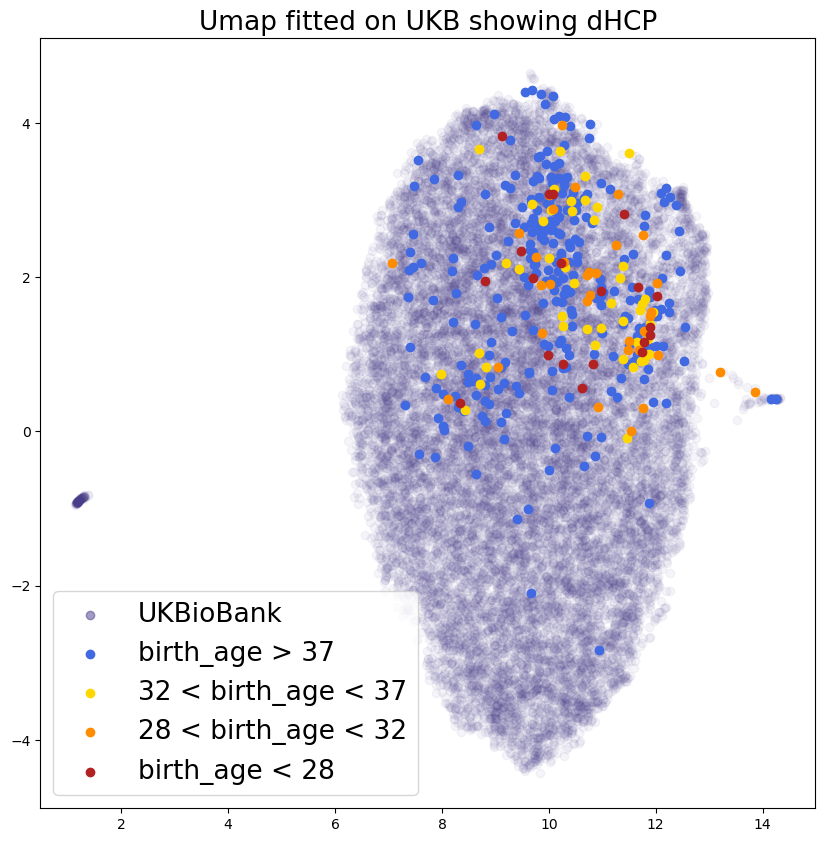

In [404]:
#split preterm and full-term
label='birth_age'
thresholds=[28,32,37]
colors=['firebrick', 'darkorange', 'gold','royalblue']

fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(ukb_embeddings['dim1'], ukb_embeddings['dim2'], color='darkslateblue', label='UKBioBank', alpha=0.05)
plot_umap(dHCP_embeddings, label, thresholds, colors, ax, title='Umap fitted on UKB showing dHCP', fontsize=19, transparency_full_term=1)
plt.savefig(save_dir+'UMAP_ukb_dHCP.png', facecolor='white')
plt.show()

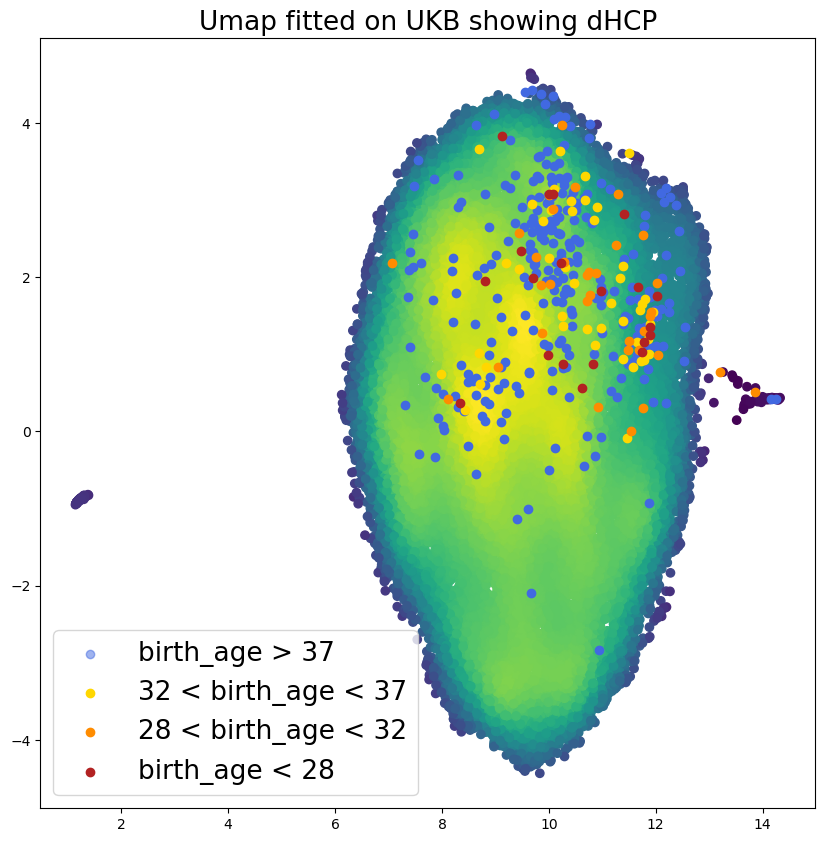

In [405]:
# plot full-term density
fig, ax = plt.subplots(figsize=(10,10))
x, y  = ukb_embeddings['dim1'].to_numpy(), ukb_embeddings['dim2'].to_numpy()
# Calculate the point density
xy = np.vstack([x,y])
z = scipy.stats.gaussian_kde(xy)(xy)
plt.scatter(x, y, c=z)
plot_umap(dHCP_embeddings, label, thresholds, colors, ax, title='Umap fitted on UKB showing dHCP', fontsize=19, transparency_full_term=1)
plt.show()

In [406]:
# SimCLR top-predicted full-terms

TN = ['CC00455XX10', 'CC00139XX16', 'CC00948XX25', 'CC00153XX05',
       'CC01086XX15', 'CC00458XX13', 'CC00402XX06', 'CC00130XX07',
       'CC00203XX05', 'CC00145XX14', 'CC00508XX13', 'CC00858XX17',
       'CC00861XX12', 'CC00914XX15', 'CC00270XX07', 'CC00549XX22',
       'CC00088XX15', 'CC00356XX10']


# BetaVAE top-predicted full-terms
TN = ['CC00270XX07', 'CC00348XX19', 'CC00653XX10', 'CC00584XX16',
 'CC00080XX07', 'CC00300XX03', 'CC00269XX14', 'CC00852XX11',
 'CC00431XX11', 'CC00325XX12', 'CC00380XX10', 'CC00791XX17',
 'CC00130XX07', 'CC00088XX15', 'CC00688XX21', 'CC00455XX10',
 'CC00091XX10', 'CC00139XX16']

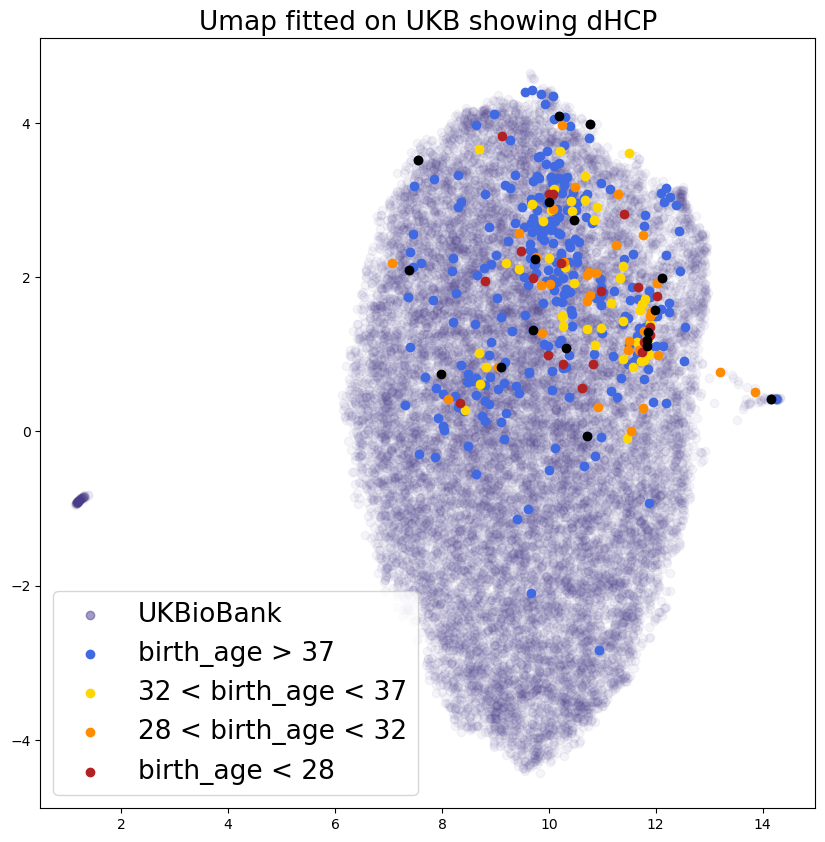

In [407]:
# color top-predicted full-terms differently
TN_embeddings = dHCP_embeddings.loc[dHCP_embeddings['subject'].isin(TN)]

#split preterm and not preterm
label='birth_age'
thresholds=[28,32,37]
colors=['firebrick', 'darkorange', 'gold','royalblue']

fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(ukb_embeddings['dim1'], ukb_embeddings['dim2'], color='darkslateblue', label='UKBioBank', alpha=0.05)
plot_umap(dHCP_embeddings, label, thresholds, colors, ax, title='Umap fitted on UKB showing dHCP', fontsize=19, transparency_full_term=1)
plt.scatter(TN_embeddings['dim1'], TN_embeddings['dim2'], color='black', label='Top-predicted full-terms')
#plt.savefig(save_dir+'UMAP_ukb_dHCP_top_predicted.png', facecolor='white')
plt.show()

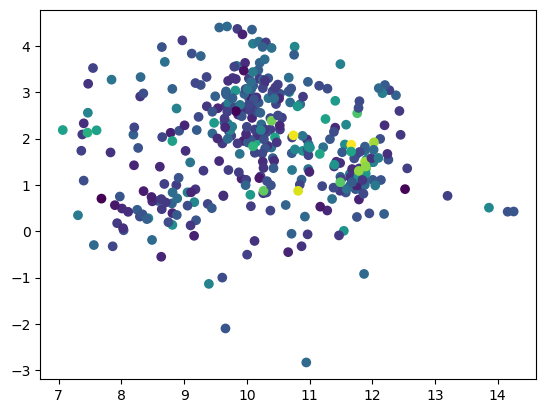

In [408]:
# plot var value on UMAP
# are there regions with higher variability ?
embedding= dHCP_embeddings[['dim1', 'dim2']]
x = embedding['dim1']
y = embedding['dim2']

# compute var norm
dHCP_var = str_to_array(df_dhcp['var'])
var = np.linalg.norm(dHCP_var, axis=1)
plt.scatter(x, y, c=var)
plt.show()

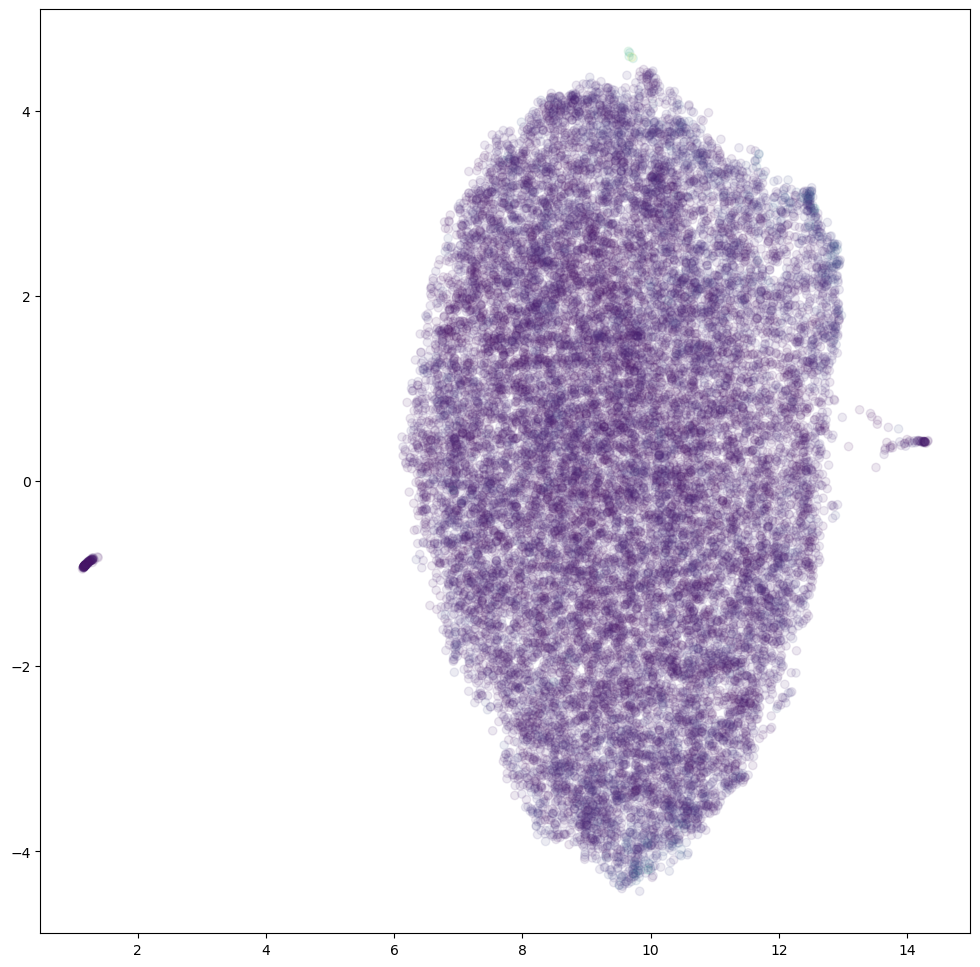

In [409]:
# same on ukb
# plot var value on UMAP
# are there regions with higher variability ?
fig, ax = plt.subplots(figsize=(12,12))
embedding= ukb_embeddings[['dim1', 'dim2']]
x = embedding['dim1']
y = embedding['dim2']

# compute var norm
ukb_var = str_to_array(df_ukb['var'])
var = np.linalg.norm(ukb_var, axis=1)
plt.scatter(x, y, c=var, alpha=0.1)
plt.show()

# Clustering

centroid cluster 0: (11.632228, 1.3554008), nb subjects: 124
centroid cluster 1: (8.168712, 2.420252), nb subjects: 30
centroid cluster 2: (9.051263, 0.44453144), nb subjects: 71
centroid cluster 3: (10.095696, 2.8121562), nb subjects: 149


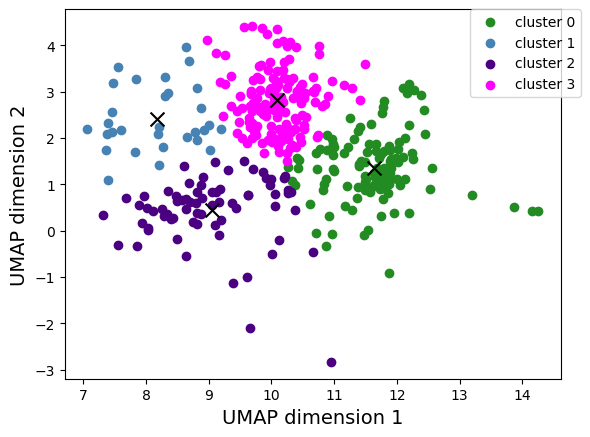

In [410]:
# clusters dHCP on UMAP
n_clusters = 4
embedding= dHCP_embeddings[['dim1', 'dim2']]
remove_outliers=False
## NB : RESOLVE BUG WITH REMOVE OUTLIERS: THE SUBJECT NAMES ARE SHIFTED !!

# remove outlier # ADAPT TO EACH MODEL
if remove_outliers:
    embedding_no_outliers = embedding.copy()
    idxs = np.where(embedding['dim1'] < 4)[0]
    for elem in idxs:
        embedding_no_outliers = embedding_no_outliers.T
        embedding_no_outliers.pop(elem)
        print(f'subject {elem} removed')
        embedding_no_outliers = embedding_no_outliers.T
    embedding_no_outliers.reset_index(inplace=True, drop=True)

    cluster_labels= KMeans(n_clusters=n_clusters, random_state=0).fit_predict(embedding_no_outliers)

    dstrb_clu = embedding_no_outliers.copy()
else:
    cluster_labels= KMeans(n_clusters=n_clusters, random_state=0).fit_predict(embedding)
    dstrb_clu = embedding.copy()
    
dstrb_clu['cluster_lab'] = cluster_labels

arr = np.array([np.array([dstrb_clu[k][i] for k in dstrb_clu.columns[:2]]) for i in range(len(dstrb_clu))])
centroid_list = []

color_dict = {0:'forestgreen',1: 'steelblue', 2:'indigo', 3:'magenta', 4:'darkred', 5: 'yellow', 6: 'red', 7: 'green', 8: 'gray', 9: 'purple'}
fig, ax = plt.subplots()

for g in np.unique([dstrb_clu.cluster_lab]):
    ix = np.where(dstrb_clu.cluster_lab == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"cluster {g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    centroid = (np.mean(x), np.mean(y))
    print(f'centroid cluster {g}: {centroid}, nb subjects: {len(x)}')
    ax.scatter(centroid[0], centroid[1], marker='x', color='k', s=100)
    centroid_list.append(centroid)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
if not os.path.isdir(save_dir+'/clustering/'):
    os.mkdir(save_dir+'/clustering/')
plt.savefig(save_dir+'/clustering/'+'Clustering_UMAP.png', facecolor='white')
plt.show()

In [411]:
# match dHCP preterms with indexes
dataset = "dHCP_374_subjects" # useless ?
config = preprocess_config(model_dir, dataset)
ordered_subjects = pd.read_csv(config.subject_dir)
if ordered_subjects['Subject'][0][:4]=='sub-':
    ordered_subjects['Subject'] = [sub[4:] for sub in ordered_subjects['Subject'].tolist()]
ordered_subjects.columns=['sub']

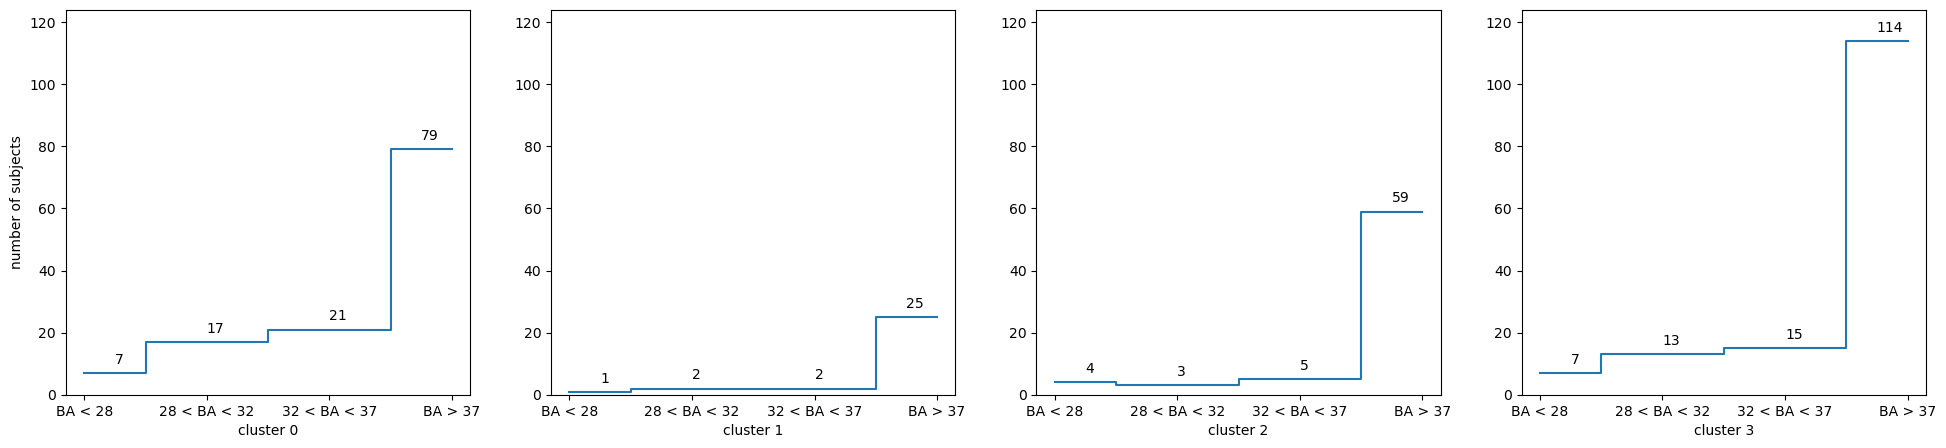

In [412]:
# for each cluster, measure the birth age distribution
x_label = ['BA < 28', '28 < BA < 32', '32 < BA < 37', 'BA > 37']

fig, axs = plt.subplots(ncols=n_clusters, figsize=(24,5))
fig.canvas.draw()
dstrb_clus = dstrb_clu.copy()
dstrb_clus['sub'] = ordered_subjects['sub']
dstrb_clus = pd.merge(dstrb_clus, info_dHCP, on='sub')
maxi=0
for k in range(n_clusters):
    age_clu = dstrb_clus.loc[dstrb_clus['cluster_lab']==k]['birth_age'].tolist()
    nb_sub_clu = [0, 0, 0, 0]
    for age in age_clu:
        if age < 28:
            nb_sub_clu[0]+=1
        elif age < 32:
            nb_sub_clu[1]+=1
        elif age < 37:
            nb_sub_clu[2]+=1
        else:
            nb_sub_clu[3]+=1
    maxi = max(maxi, max(nb_sub_clu))
    #axs[k].hist(age_clu, bins=[23, 28, 32, 37, 44])
    axs[k].step(x_label, nb_sub_clu, where='mid')
    axs[k].set_xlabel(f'cluster {k}')
    text_x = np.array([0.25, 1, 2, 2.75])
    text_y = [nb+3 for nb in nb_sub_clu]
    for t, tx, ty in zip(nb_sub_clu, text_x, text_y):
        axs[k].text(tx, ty , t)
    for k in range(n_clusters):
        axs[k].set_ylim([0, maxi+10])
    #axs[k].set_xticks([25, 30, 35, 40])
    #labels = [item.get_text() for item in axs[k].get_xticklabels()]
    #labels[0], labels[1], labels[2], labels[3] = ['extremely preterm', 'Very preterm', 'Moderate preterm', 'full-term']
    #axs[k].set_xticklabels(labels)
axs[0].set_ylabel('number of subjects')
plt.savefig(save_dir+'/clustering/'+'histogram_classes.png', facecolor='white')
plt.show()

# Visu clusters

In [413]:
nb_subjects_center = 20

In [414]:
def closest_distance(centroid, df, nb):


    # df must have as many columns as dimensions to consider
    distances = {}
    # Get distances to centroid for each point
    for sub in list(df.index):
        pos = [df.loc[sub][k] for k in range(1, len(df.columns)+1)]
        distances[sub] = distance.euclidean(pos, centroid)
    distances = pd.DataFrame.from_dict(distances, orient='index')
    distances.columns=['dist']
    distances = distances.sort_values(by='dist', axis=0)
    # Get closest point to centroid
    #central_point = min(distances, key=distances.get)
    central_points = list(distances.index)[:nb]
    return central_points

In [415]:
df = pd.DataFrame(embedding.to_numpy(), index=df_dhcp['sub'].tolist(), columns = [k for k in range(1, embedding.shape[1]+1)])

In [416]:
center_subjects = {f'cluster {k}': [] for k in range(n_clusters)}
for i, centroid in enumerate(centroid_list):
    subjects = closest_distance(centroid, df, nb_subjects_center)
    for subject in subjects:
        #print(f'cluster {i}, {subject}: {df.loc[subject].to_numpy()}')
        center_subjects[f'cluster {i}'].append(subject)

In [417]:
idxs_centroids =  {f'cluster {k}': [] for k in range(n_clusters)}
for i in range(n_clusters):
    idxs_centroids[f'cluster {i}'] = [ordered_subjects.loc[ordered_subjects['sub']==center_subjects[f'cluster {i}'][k]].index.tolist()[0] for k in range(len(center_subjects[f'cluster {i}']))]

In [418]:
# now find center_subjects in ukb
df = pd.DataFrame(ukb_embeddings.to_numpy(), index=df_ukb['sub'].tolist(), columns = [k for k in range(1, embedding.shape[1]+1)])
center_subjects_ukb = {f'cluster {k}': [] for k in range(n_clusters)}
for i, centroid in enumerate(centroid_list):
    subjects = closest_distance(centroid, df, nb_subjects_center)
    for subject in subjects:
        #print(f'cluster {i}, {subject}: {df.loc[subject].to_numpy()}')
        center_subjects_ukb[f'cluster {i}'].append(subject)

# match ukb idxs with subjects
dataset = "UkBioBank"
config = preprocess_config(model_dir, dataset)
ordered_subjects_ukb = pd.read_csv(config.subject_dir)
if ordered_subjects_ukb['Subject'][0][:4]=='sub-':
    ordered_subjects_ukb['Subject'] = np.array([sub[4:] for sub in ordered_subjects_ukb['Subject'].tolist()]).astype(int)
ordered_subjects_ukb.columns=['sub']

idxs_centroids_ukb =  {f'cluster {k}': [] for k in range(n_clusters)}
for i in range(n_clusters):
    idxs_centroids_ukb[f'cluster {i}'] = [ordered_subjects_ukb.loc[ordered_subjects_ukb['sub']==center_subjects_ukb[f'cluster {i}'][k]].index.tolist()[0] for k in range(len(center_subjects_ukb[f'cluster {i}']))]

load reconstructions

In [451]:
# first get the side from config name
if '_left_' in config.dataset_name or '_L_' in config.dataset_name:
    side=['left', 'L']
elif '_right_' in config.dataset_name or '_R_' in config.dataset_name:
    side=['right', 'R']
else:
    print('Invalid config name')

In [456]:
# load reconstructions # TO RECODE USING CONFIG
# le plus simple: regarder s'il y a right ou left dans la config ! dans le nom

dHCP_reconstructions = np.load(config.save_dir+ 'dHCP_374_subjects_skeleton_reconstructed.npy')
ukb_reconstructions = np.load(config.save_dir + 'UkBioBank_skeleton_reconstructed.npy')

In [297]:
# load skeletons
#ukb_skeletons = np.load(f'/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/crops/2mm/{sulcus}.baby/mask/Rskeleton.npy')
ukb_skeletons = np.load(config.data_dir+'/../'+f'{side[1]}skeleton.npy') # fonctionne pas ... + très lourd
ukb_skeletons = ukb_skeletons.astype(bool)
# match ukb idxs with subjects
#ordered_subjects_ukb = pd.read_csv("/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/crops/2mm/S.T.s.baby/mask/Rskeleton_subject_int.csv", header=None)
ordered_subjects_ukb = pd.read_csv(config.data_dir+'/../'+f'{side[1]}skeleton_subject.csv')

# nécessite de modifier la config juste pour avoir dHCP... Ou bien laisser UKB et dHCP dans les noms si on ne travaille qu'avec ça ?
#dHCP_skeletons = np.load(f'/neurospin/dico/data/deep_folding/current/datasets/dHCP_374_subjects/crops/2mm/{sulcus}.baby/mask/Rskeleton.npy')
dHCP_skeletons = dHCP_skeletons.astype(bool)

# pad skeletons
def apply_padding(shape, arr, fill_value=0):
    """ See Padding.__call__().
    """
    orig_shape = arr.shape
    padding = []
    for orig_i, final_i in zip(orig_shape, shape):
        shape_i = final_i - orig_i
        half_shape_i = shape_i // 2
        if shape_i % 2 == 0:
            padding.append((half_shape_i, half_shape_i))
        else:
            padding.append((half_shape_i, half_shape_i + 1))
    for cnt in range(len(arr.shape) - len(padding)):
        padding.append((0, 0))

    fill_arr = np.pad(arr, padding, mode="constant", constant_values=fill_value)
        
    return(fill_arr)

#dHCP
skel_list = []
for skel in dHCP_skeletons:
     sk = apply_padding(crop_size, skel)
     skel_list.append(np.expand_dims(sk,axis=0))
dHCP_skels = np.vstack(skel_list)
dHCP_skels = dHCP_skels.squeeze()

#ukb
skel_list = []
for skel in ukb_skeletons:
     sk = apply_padding(crop_size, skel)
     skel_list.append(np.expand_dims(sk,axis=0))
ukb_skels = np.vstack(skel_list)
ukb_skels = ukb_skels.squeeze()

# Reconstructions dHCP

by cluster

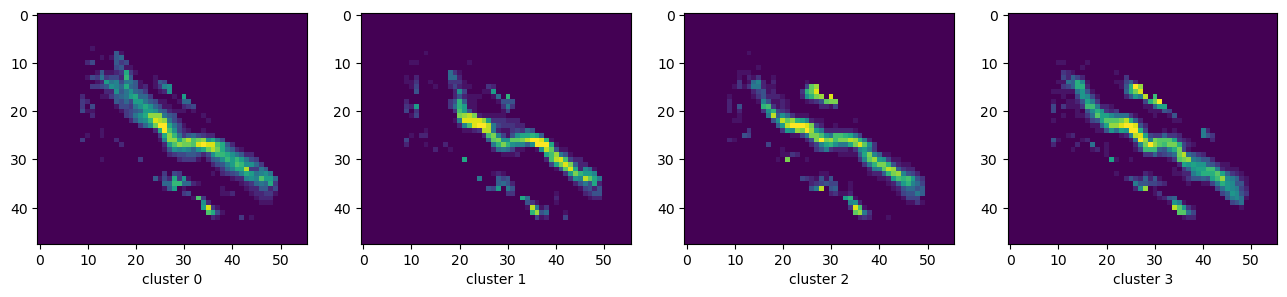

In [342]:
# average
depth=13
fig, axs = plt.subplots(ncols=len(idxs_centroids.keys()), figsize=(len(idxs_centroids)*4,4))
for k, (key, values) in enumerate(idxs_centroids.items()):
    im_l = []
    for i, idx in enumerate(values):
        input = np.rot90(dHCP_skels[idx][depth,:,:], axes=(1, 0))
        im = np.rot90(dHCP_reconstructions[idx][depth,:,:], axes=(1, 0)).astype(int)
        im_l.append(im)
    a = np.sum(im_l, axis=0)
    axs[k].imshow(a)
    axs[k].set_xlabel(key)
dir_to_save = f'/home/jl274628/Documents/BETA_VAE/clustering/Reconstructions/{model_name}/dHCP/'
if not os.path.isdir(dir_to_save):
    os.makedirs(dir_to_save)
if sampling:
    plt.savefig(dir_to_save+f'Reconstruction_cluster_average.png', facecolor='white')
else:
    plt.savefig(dir_to_save+f'Reconstruction_cluster_average_no_sampling.png', facecolor='white')

plt.show()

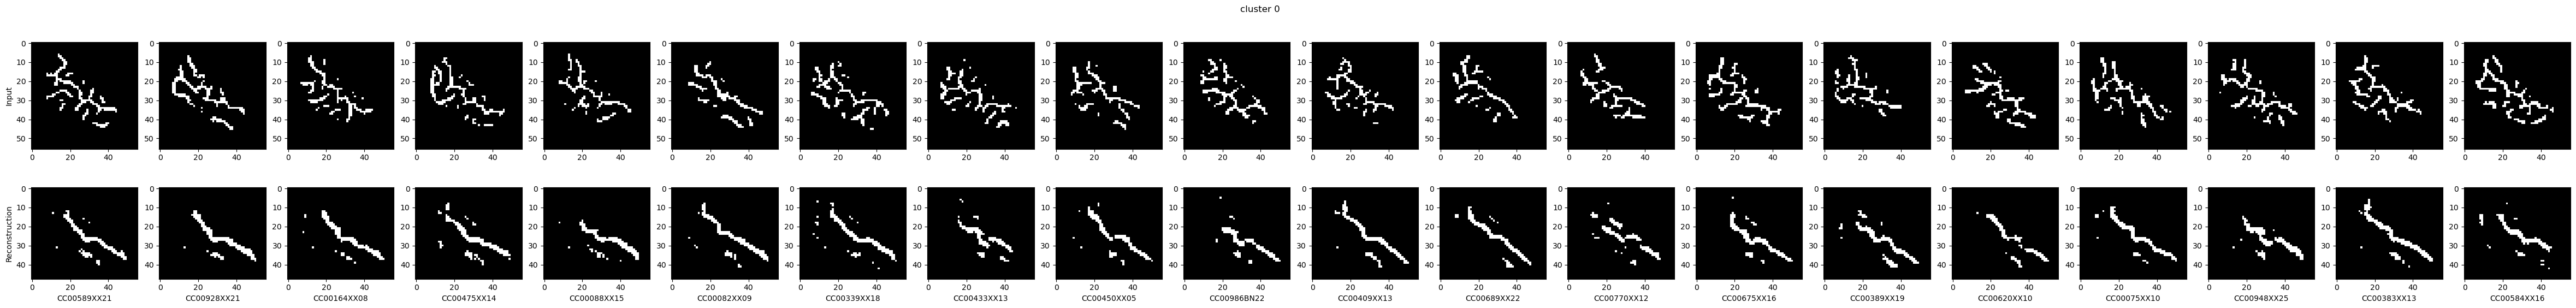

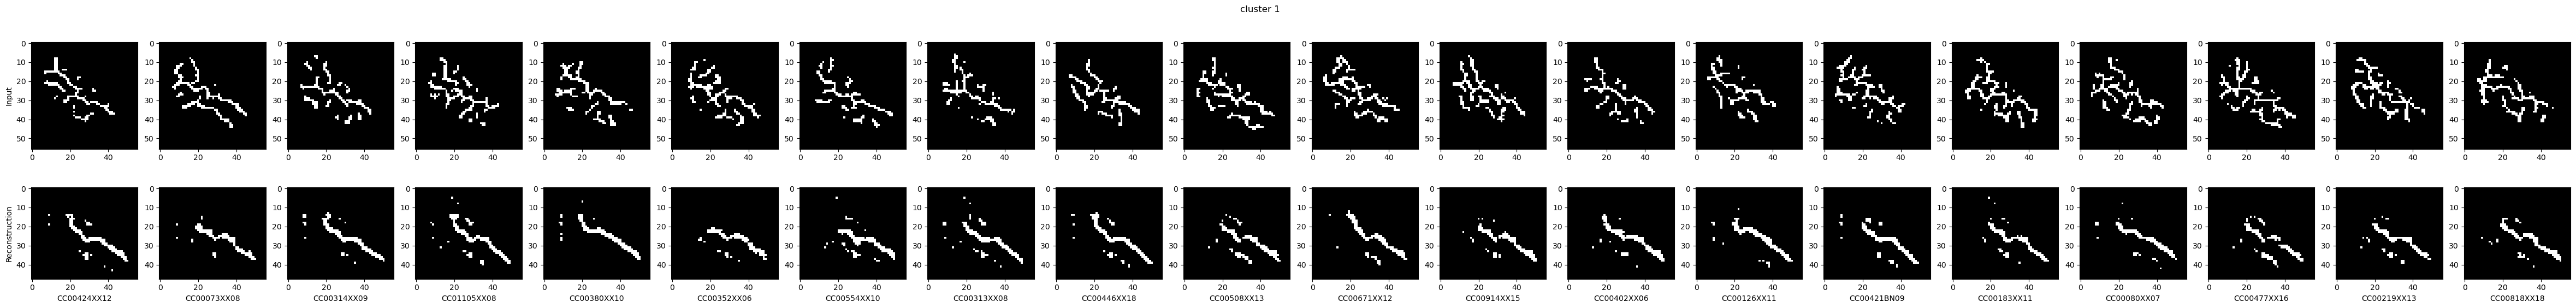

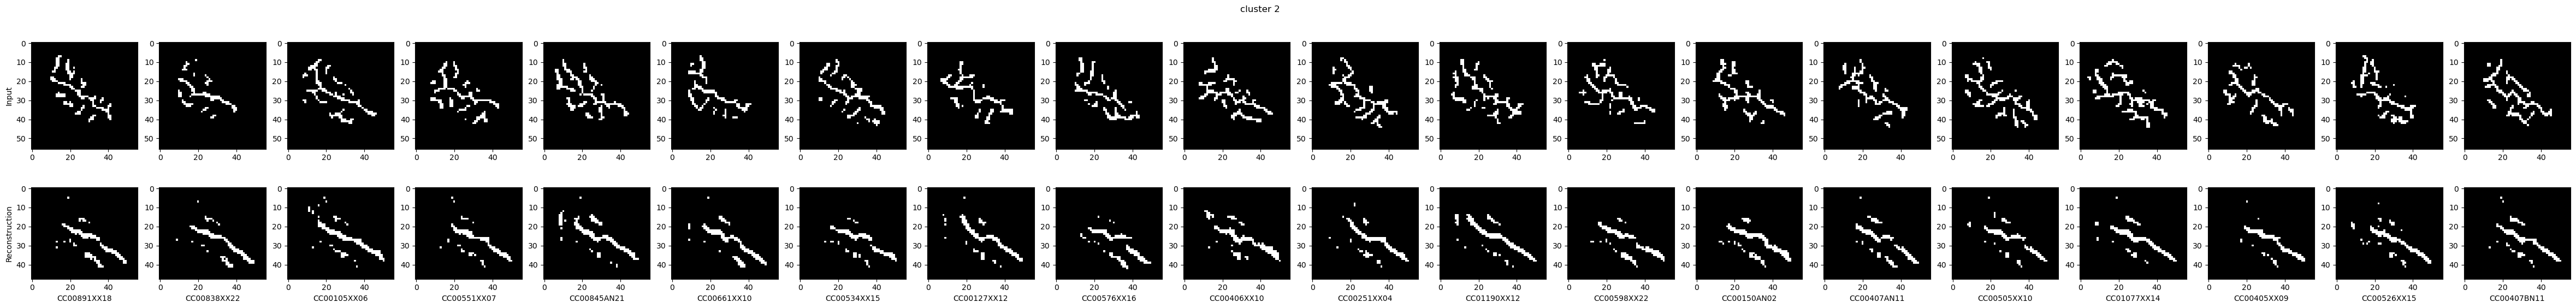

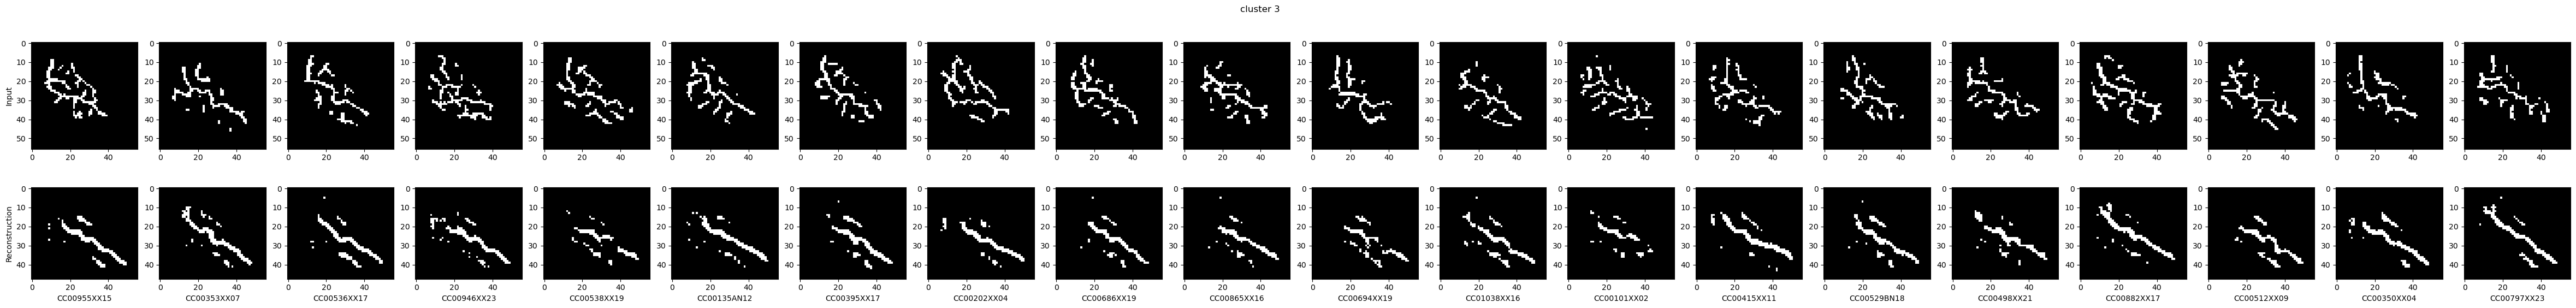

In [343]:
# plot recons
depth = 14
for k, ((_, values), (_, subjects)) in enumerate(zip(idxs_centroids.items(), center_subjects.items())):
    fig, axs = plt.subplots(ncols=nb_subjects_center, nrows=2, figsize=(nb_subjects_center*3,6))
    for i, (idx, subject) in enumerate(zip(values, subjects)):
        input = np.rot90(dHCP_skels[idx][depth,:,:], axes=(1, 0))
        im = np.rot90(dHCP_reconstructions[idx][depth,:,:], axes=(1, 0))
        #im = morphology.remove_small_objects(im, min_size=3, connectivity=3)
        axs[0,i].imshow(input, cmap='gray')
        axs[1,i].imshow(im, cmap='gray')
        axs[1,i].set_xlabel(subject)
        #axs[1,k].set_xlabel(f'cluster {k}')
    axs[0, 0].set_ylabel('Input')
    axs[1, 0].set_ylabel('Reconstruction')
    plt.suptitle(f'cluster {k}')
    if sampling:
        plt.savefig(dir_to_save+f'Reconstruction_cluster_{k}.png', facecolor='white')
    else:
        plt.savefig(dir_to_save+f'Reconstruction_cluster_{k}_no_sampling.png', facecolor='white')

plt.show()

# Reconstructions UKB

by cluster

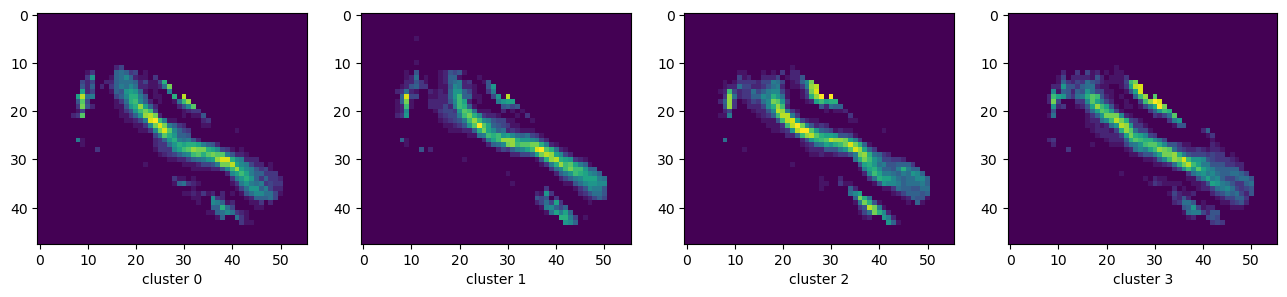

In [344]:
depth=13
fig, axs = plt.subplots(ncols=len(idxs_centroids_ukb.keys()), figsize=(len(idxs_centroids)*4,4))
for k, (key, values) in enumerate(idxs_centroids_ukb.items()):
    im_l = []
    for i, idx in enumerate(values):
        input = np.rot90(ukb_skels[idx][depth,:,:], axes=(1, 0))
        im = np.rot90(ukb_reconstructions[idx][depth,:,:], axes=(1, 0)).astype(int)
        im_l.append(im)
    a = np.sum(im_l, axis=0)
    axs[k].imshow(a)
    axs[k].set_xlabel(key)
dir_to_save=f'/home/jl274628/Documents/BETA_VAE/clustering/Reconstructions/{model_name}/ukb/'
if not os.path.isdir(dir_to_save):
    os.makedirs(dir_to_save)
if sampling:
    plt.savefig(dir_to_save+f'Reconstruction_cluster_average.png', facecolor='white')
else:
    plt.savefig(dir_to_save+f'Reconstruction_cluster_average_no_sampling.png', facecolor='white')

plt.show()

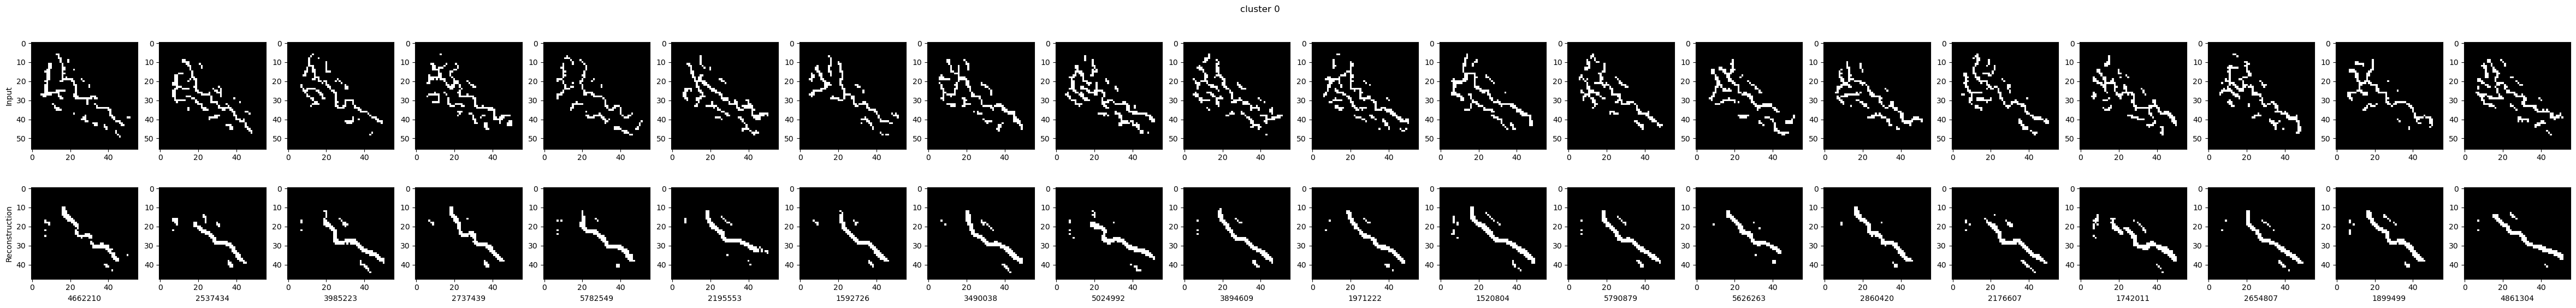

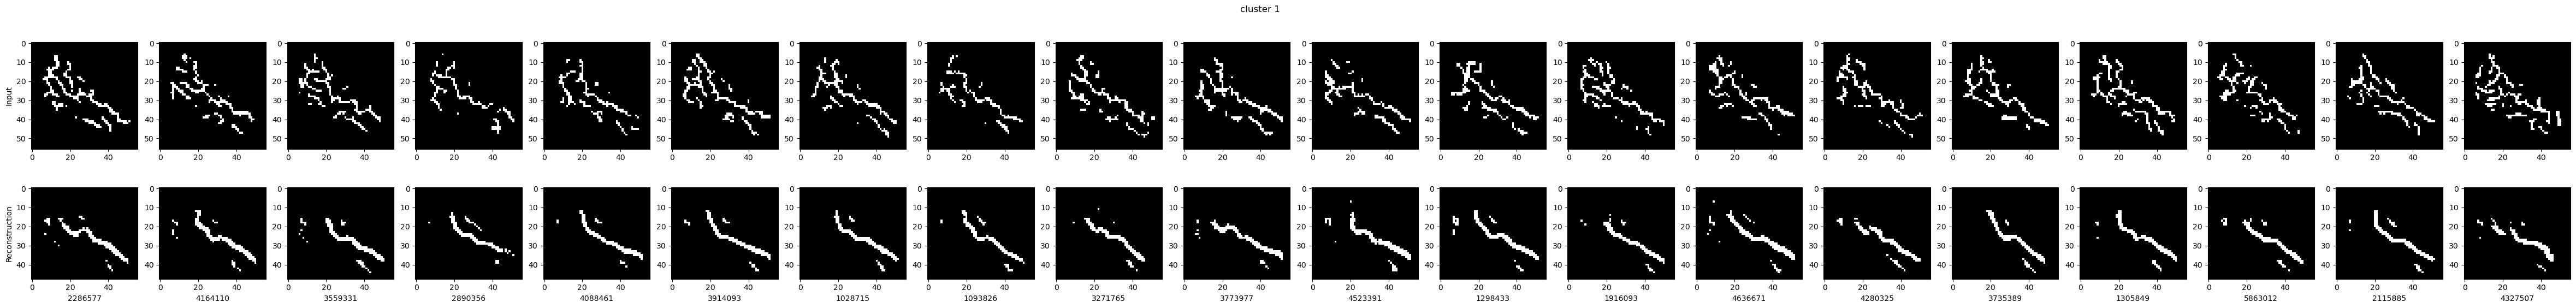

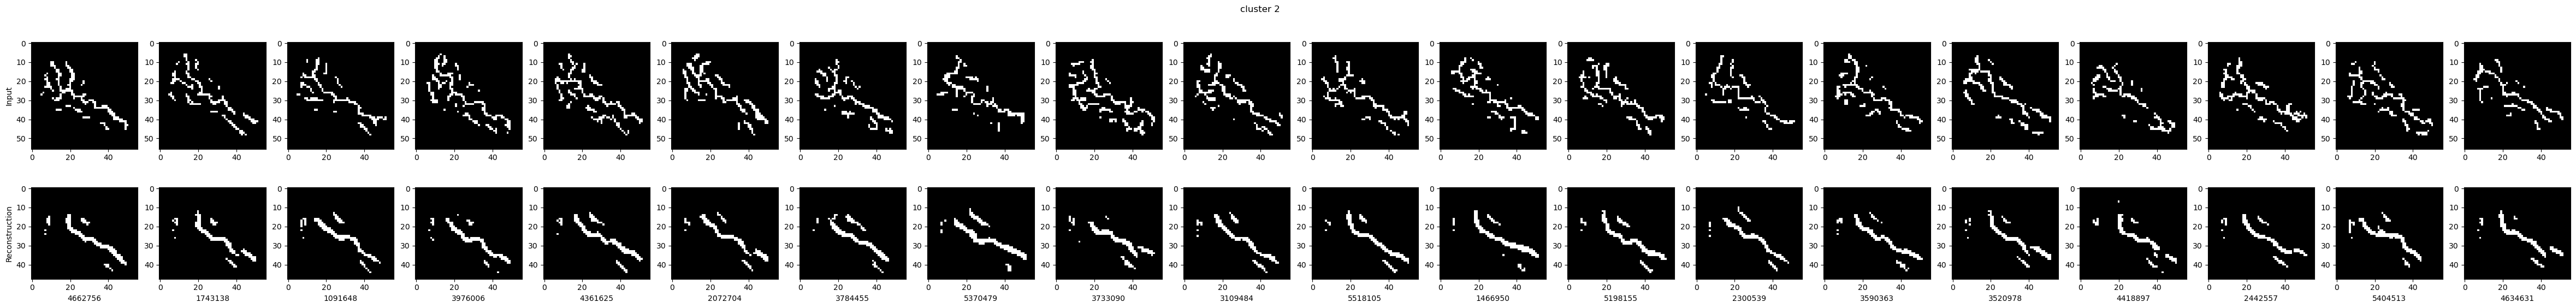

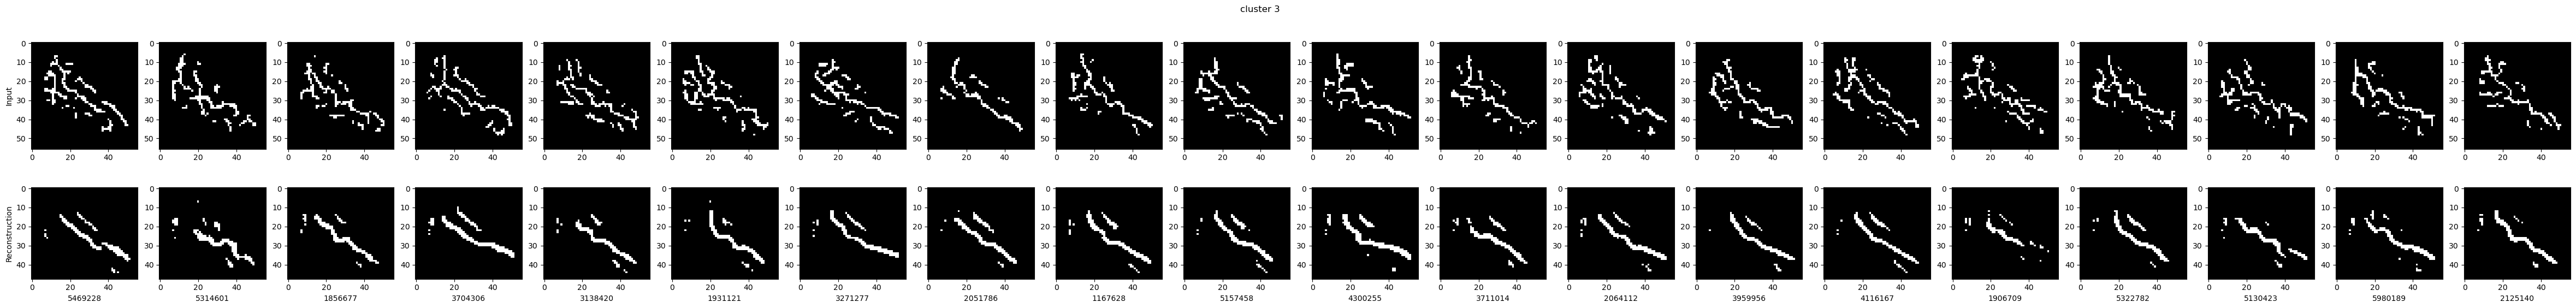

In [345]:
# plot recons
depth = 14
for k, ((_, values), (_, subjects)) in enumerate(zip(idxs_centroids_ukb.items(), center_subjects_ukb.items())):
    fig, axs = plt.subplots(ncols=nb_subjects_center, nrows=2, figsize=(nb_subjects_center*3,6))
    for i, (idx, subject) in enumerate(zip(values, subjects)):
        input = np.rot90(ukb_skels[idx][depth,:,:], axes=(1, 0))
        im = np.rot90(ukb_reconstructions[idx][depth,:,:], axes=(1, 0))
        #im = morphology.remove_small_objects(im, min_size=3, connectivity=3)
        axs[0,i].imshow(input, cmap='gray')
        axs[1,i].imshow(im, cmap='gray')
        axs[1,i].set_xlabel(subject)
        #axs[1,k].set_xlabel(f'cluster {k}')
    axs[0, 0].set_ylabel('Input')
    axs[1, 0].set_ylabel('Reconstruction')
    plt.suptitle(f'cluster {k}')
    #plt.savefig(save_dir+'/clustering/'+f'Reconstruction_ukb_cluster_{k}_no_sampling.png', facecolor='white')
    if sampling:
        plt.savefig(dir_to_save+f'Reconstruction_cluster_{k}.png', facecolor='white')
    else:
        plt.savefig(dir_to_save+f'Reconstruction_cluster_{k}_no_sampling.png', facecolor='white')

plt.show()

model 16-56-49 :

-Observation générale: clusters qui ne découpent pas les prémas de manière très nette. les sillons ont l'air d'être recalés naturellement. Pas de param positionnel encodé ? Regarder les corrélations avec la morpho positionnelle ? La partie antérieure est très constante, la variabilité se trouve plutôt en postérieur ? Opposition à SimCLR ?

-cluster 0: branche verticale par rapport au STS en postérieur: qui donne l'impression d'une double marche ? Sinon globalement long et régulier. Pas d'interruptions. (cluster géant avec un peu de tout)

-cluster 1: globalement plat, branche ascendante dans un prolongement plus linéaire sans escalier. 2 bizarres (interruption et forme très étrange): mal reconstruit, ce qui peut expliquer l'absence d'équerre détectées ? Peut-être voit-on là la limite de finesse du modèle, qui pourrait peut-être les voir comme des anomalies sinon... Mais l'espace latent est de petite taille, donc les représentations s'en tiennent probablement à de la variabilité récurrente, et ce genre de sujet se retrouve à une position un peu arbitraire. On voit les limites du modèle. (petit cluster, quelques prémas)

-cluster 2: Au milieu, branche STI qui remonte sur le STS ? Mais pourtant ça n'est pas visible à la reconstruction. Pas de motif très clair. (beaucoup de prémas extrêmes.)

-cluster 3: sorte de plateau, voire double plateau (plutôt au milieu de la région). Peut-être exagéré dans la reconstruction à cause de petites branches qui partent vers le haut au milieu du sillon. (quelques prémas)

model 14-10-52 : (à regarder de plus près un jour...)

-observation générale: les prémas semblent mieux clusterisés (même si les performances sont du même ordre ?)

-cluster 0: similaire au cluster 0 précédent, mais pourtant plus petit et bcp plus de prémas en proportion ? Distribution un peu à la marge.

-cluster 1: très à la marge des autres bébés sur la UMAP: effet de la UMAP ou différence très marquée ?

-cluster 3: on retrouve l'équerre, ou plateau, cluster à la marge.

Hypothèse: VAE encode plus de choses que SimCLR, mais de manière moins précise ? D'où plusieurs clusters, mais parfois moins clair ?

A faire : 
+ voir les adultes proches des centroids de chaque cluster + reconstruction = qu'est-ce qui est vraiment encodé ? Peut-être que les adultes sont beaucoup plus réguliers et que dHCP est replacé dans des zones de variabilité différentes par manque de finesse ? (cf la couronne à L75 où tous les bébés sont des anomalies..) Mais en même temps ce n'est pas full random sinon les perfs de classif seraient mauvaises. A moins que la tâche soit très simple. Supposons que la tâche soit très simple. Les prémas peuvent être séparés des autres pour des patterns réels très éloignés de ce que suggèrent les reconstructions. C'est pourquoi il faut juger la qualité des reconstructions.
+ Peut-on trouver un L pour lequel seul les prémas sont des anomalies ?

NB: il y a deux choses à distinguer.
1) les patterns de représentations qui représentent à une échelle plus ou moins fine les variantes types du STS. On les comprendrait mieux en regardant UKB (et en se restreignant aux zones des bébés). Voyager avec les adultes entre les clusters ? Ou bien simplement commencer par voir si les adultes sont plus réguliers et si les adultes de ces zones ressemblent bcp aux patterns de reconstructions vus chez les bébés.
2) les patterns réels des bébés effectivement présents dans ces clusters: peut-être sont-ils placés là par défaut, par manque de finesse (cf les bizarres) ? Si UKB dans une même zone ressemble, c'est que les bébés ne sont pas placés là par hasard. Sinon, on ne peut pas faire confiance aux patterns de reconstruction.

La valeur de la loss de reconstruction est du même ordre pour les bébés et les adultes. Mais cela veut-il dire que les vrais patterns des bébés sont aussi bien encodés que ceux des adultes ? On a peut-être un gros bruit par les branches ascendantes + l'épaisseur du sillon. Peut-être que l'erreur de reconstruction ne peut pas marcher sur les sillons trop variables. Même à L=75 ça marche pas alors que les bébés sont des anomalies dans l'espace latent ? Il faudrait peut-être faire des sortes de benchmark comme Louise, mais sur un sillon plus variable ? On peut aussi prendre des sillons qui semblent très normaux et mesurer l'erreur de reconstruction juste par les branches variables ?
De plus, si les patterns sont des formes subtiles, ça ne ressortira jamais à l'erreur de reconstruction (alors qu'une grosse interruption c'est bcp plus facile).

Il est possible que des clusters se créent mais qu'on ne puisse pour autant pas avoir confiance en les reconstructions.

En effet, les espaces latents bébés / adultes sont complètement séparables ! (CF SVC) Alors que ce n'est pas ce que suggère UMAP. Il faut le garder en tête, nottamment quand on regarde les clusters, il est probable que beaucoup de bébés soient placés à des endroits inappropriés. Les caractéristiques spécifiques de chaque cluster doivent d'abord être identifiées chez les adultes. Ensuite, on essaye de voir si elles sont correctement réutilisées chez les bébés. Point positif: les bébés n'ont pas l'air placé aléatoirement sur la UMAP, il y a tout de même une structure.

VISU cluster UKB: Il faudrait les voir en 3D. En 2D les patterns ne sont pas clair du tout. Cluster 0 (model1): utilise une branche au dessus du STS ? cluster 2 vs 3: pas la même forme antérieure ? Ressemblent-ils aux bébés ?

In [519]:
# essayer de faire un carte de variabilité ?
# Faire la somme des reconstructions pour voir quels voxels apparaissent souvent ? Comment voir lesquels sont déterminants dans les repr ?

On pourrait faire la même chose sur UKB

In [520]:
# faire une moyenne des reconstructions de chaque cluster ? Mais les knobs risquent-il de disparaître ?
# Ou bien prendre les sujets proches du centre et faire une moyenne pour débruiter la reconstruction.

# Buckets

In [521]:
# save reconstructions as buckets for 3D visualization

# UMAP fit on dHCP

/casa/home/.local/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


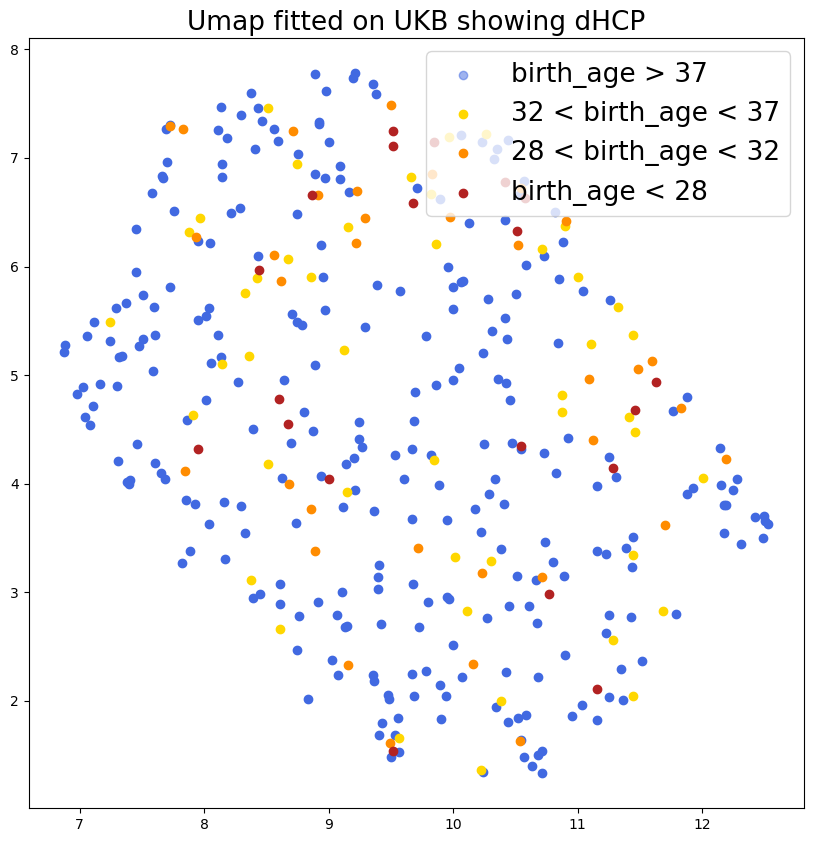

In [420]:
reducer = umap.UMAP(random_state=3)
dHCP_embedding = reducer.fit_transform(embeddings_dHCP)

dHCP_embeddings = pd.DataFrame({'dim1': dHCP_embedding[:,0], 'dim2': dHCP_embedding[:,1]})
dHCP_embeddings['birth_age'] = info_dHCP['birth_age'].tolist()

#split preterm and not preterm
label='birth_age'
thresholds=[28,32,37]
colors=['firebrick', 'darkorange', 'gold','royalblue']

fig, ax = plt.subplots(figsize=(10,10))
plot_umap(dHCP_embeddings, label, thresholds, colors, ax, title='Umap fitted on UKB showing dHCP', fontsize=19, transparency_full_term=1)
plt.savefig(save_dir+'UMAP_dHCP.png', facecolor='white')
plt.show()

NB: on semble voir les 3 clusters comme avec UKB

centroid cluster 0: (11.122443, 4.3586726)
centroid cluster 1: (9.189477, 6.6833153)
centroid cluster 2: (8.096351, 4.573709)
centroid cluster 3: (10.075906, 2.3853261)


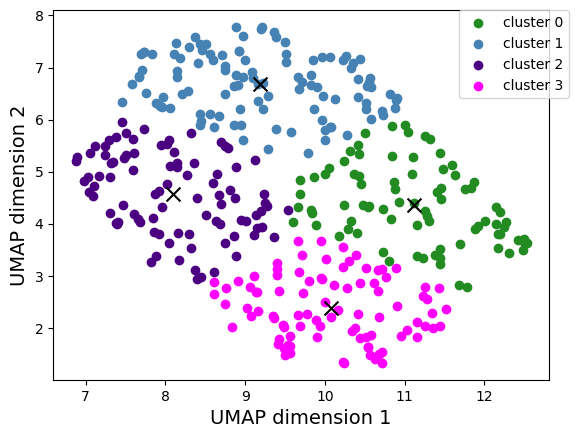

In [421]:
# clusters dHCP on UMAP
embedding= dHCP_embeddings[['dim1', 'dim2']]

cluster_labels= KMeans(n_clusters=4, random_state=0).fit_predict(embedding)
centroid_list=[]

dstrb_clu = embedding.copy()
dstrb_clu['cluster_lab'] = cluster_labels

arr = np.array([np.array([dstrb_clu[k][i] for k in dstrb_clu.columns[:2]]) for i in range(len(dstrb_clu))])

color_dict = {0:'forestgreen',1: 'steelblue', 2:'indigo', 3:'magenta'}
fig, ax = plt.subplots()

for g in np.unique([dstrb_clu.cluster_lab]):
    ix = np.where(dstrb_clu.cluster_lab == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"cluster {g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    centroid = (np.mean(x), np.mean(y))
    print(f'centroid cluster {g}: {centroid}')
    ax.scatter(centroid[0], centroid[1], marker='x', color='k', s=100)
    centroid_list.append(centroid)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

1) Essayer 10 dims ? Laisser Beta=2 ? Mais quelle reconstruction avec n=10 ?
2) Loss Beta sans impact implique overfitting et donc mauvaise reconstruction de nouveaux échantillons = on pourrait essayer pour avoir une idée ?
2) Visualiser les reconstructions des sujets dans chaque cluster, et les interruptions sont-elles vues ? Trouver un notebook de Louise.
3) SVM protocol sur la latente ? Mais à 75 dims ? ou bien sur UMAP ? Qu'à fait Louise ? Faire à 10 dims pour comparer avec SimCLR ? + metrique reconstruction 10 DIMENSIONS A L'AIR TRES MAL RECONSTRUIT, MAIS C'EST PEUT-ETRE UN PEU UNE QUESTION DE LOSS AUSSI ? PAR CONTRE LA LATENTE A L'AIR D'ENCODER QUELQUES CHOSE, IL FAUT CALCULER SVM + FAIRE L'ETUDE DE VARIABILITE. PAS DE POINT ATTRACTEUR MAIS UNE POLARISATION.
4) lire la partie de la thèse de Louise sur l'optimisation des paramètres pour savoir quelle trend doit avoir KL à l'entraînement + regarder la qualité de reconstruction dans le cas d'un nouveau point ? Y a-t-il vraiment une continuité ? + loss KL de val beaucoup plus faible que celle de train: explication ? QUELLES ÉTAIENT LES LOSS TYPIQUES DE LOUISE ?
5) Erreur de reconstruction: l'épaisseur du resampling joue-t-elle un rôle ? On dirait que la loss peut être élevée alors que la forme est correcte. Faudrait-il contraindre l'épaisseur ? Ne pas en tenir compte dans la loss ? Utiliser des distance maps pour éviter le problème ?
6) potentielle solution pour la reconstruction: mettre une non-linéarité avec erreur par patch ? + somme quadratique par exemple ?

Priorité:

Avec 10 dims,
1) variabilité + p-value
2) SVM classif.

## Variability

In [422]:
scaler = StandardScaler()
#space="UMAP"
space="latent"
metric='euclidean'

if space=="UMAP":
    df = dHCP_embeddings.copy()
    dims = dims=[f'dim{k}' for k in range(1,3)]
    binwidth=0.5
    height=0.6
    maxi_hist=1000

elif space=="latent":
    dims = dims=[f'dim{k}' for k in range(1,embeddings_dHCP.shape[1]+1)]
    df = pd.DataFrame(embeddings_dHCP, columns=dims)
    df['birth_age']=df_dhcp['birth_age'].tolist()
    binwidth=0.5
    height=0.6
    maxi_hist=1000

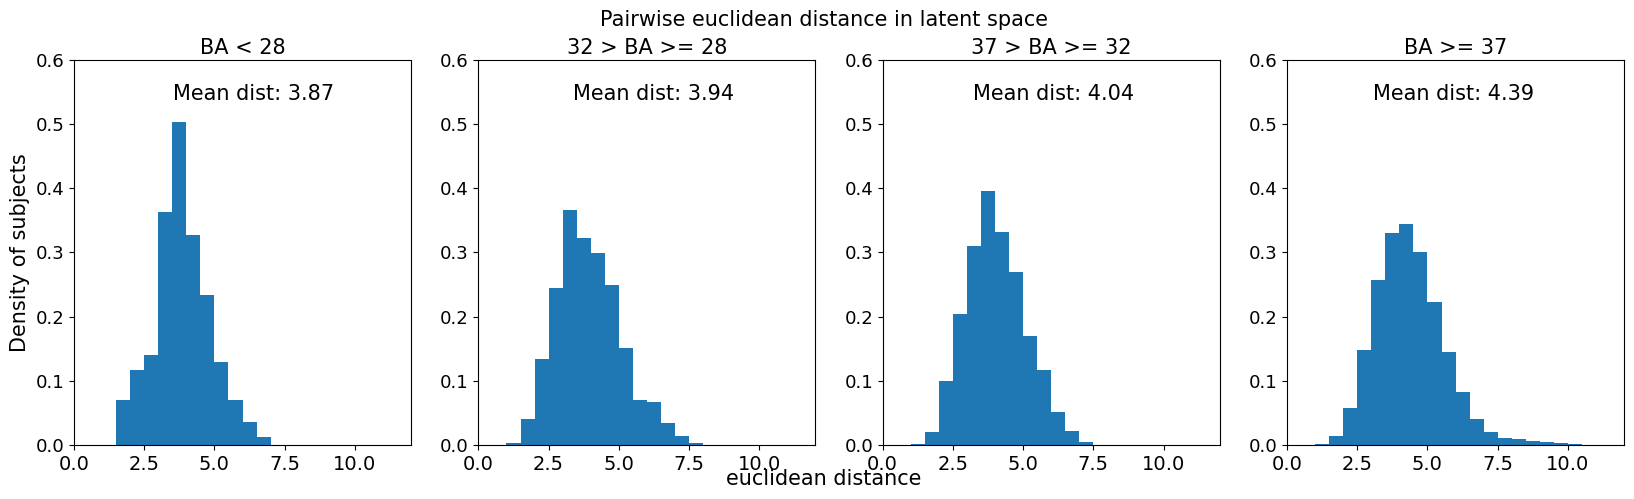

In [423]:
# normalize dims
for dim in dims:
    x = df[dim].to_numpy().reshape(-1,1)
    x = scaler.fit_transform(x)
    df[dim] = x

thresholds=[28, 32, 37]
subsample=-1

fig, axs = plt.subplots(ncols=len(thresholds)+1, figsize=(5*(len(thresholds)+1),5))
maxi=0
for idx in range(len(thresholds)+1):
    ax = axs[idx]
    if idx==0:
        sub_df = df.loc[df['birth_age']<thresholds[0]]
        ax.set_xlabel(f'BA < {thresholds[0]}', fontsize=15)
    elif idx==len(thresholds):
        sub_df = df.loc[df['birth_age']>=thresholds[-1]]
        ax.set_xlabel(f'BA >= {thresholds[-1]}', fontsize=15)
    else:
        sub_df = df.loc[(df['birth_age']>=thresholds[idx-1]) & (df['birth_age']<thresholds[idx])]
        ax.set_xlabel(f'{thresholds[idx]} > BA >= {thresholds[idx-1]}', fontsize=15)
    ax.xaxis.set_label_position('top') 
    if subsample != -1:
        sub_df = sub_df.sample(subsample, random_state=7)
    pos_matrix = sub_df[dims].to_numpy()
    dists = pairwise_distances(pos_matrix, metric=metric)
    dists = np.tril(dists)
    dists = dists.reshape(-1,1)
    dists = list(dists[:, 0])
    dists = [d for d in dists if d!=0]
    maxi = max(np.max(dists), maxi)

    ax.hist(dists, density=True, bins=np.arange(0, maxi_hist + binwidth, binwidth))
    fig.text(0.015+0.2*(idx+1), 0.8, f'Mean dist: {np.mean(dists):.2f}', ha='center', fontsize=15)


for idx in range(len(thresholds)+1):
    axs[idx].set_xlim(0, maxi)
    axs[idx].set_ylim(0, height)
    axs[idx].tick_params(axis='x', labelsize=14)
    axs[idx].tick_params(axis='y', labelsize=13)
    if idx==0:
        axs[idx].set_ylabel('Density of subjects', fontsize=15)
plt.suptitle(f'Pairwise {metric} distance in {space} space', fontsize=15)
to_keep = plt.text(x=0.5, y=0.03, s=f"{metric} distance", fontsize=15, ha="center", transform=fig.transFigure)

plt.savefig(save_dir+f'/pairwise_{metric}_distance_{space}.jpg')

plt.show()

In [424]:
dists_dict = {f'BA < {thresholds[0]}' :[],
        f'{thresholds[1]} > BA >= {thresholds[0]}': [],
        f'{thresholds[2]} > BA >= {thresholds[1]}': [],
        f'BA >= {thresholds[-1]}': []}

for idx in range(len(thresholds)+1):
    ax = axs[idx]
    if idx==0:
        sub_df = df.loc[df['birth_age']<thresholds[0]]
        label = f'BA < {thresholds[0]}'
    elif idx==len(thresholds):
        sub_df = df.loc[df['birth_age']>=thresholds[-1]]
        label = f'BA >= {thresholds[-1]}'
    else:
        sub_df = df.loc[(df['birth_age']>=thresholds[idx-1]) & (df['birth_age']<thresholds[idx])]
        label = f'{thresholds[idx]} > BA >= {thresholds[idx-1]}'
    ax.set_xlabel(label)
    ax.xaxis.set_label_position('top') 

    pos_matrix = sub_df[dims].to_numpy()
    dists = pairwise_distances(pos_matrix, metric=metric)
    dists = np.tril(dists)
    dists = dists.reshape(-1,1)
    dists = list(dists[:, 0])
    dists = [d for d in dists if d!=0]
    dists_dict[label].append(dists)

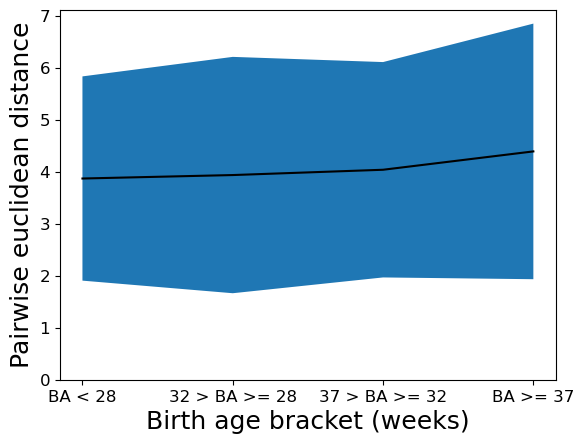

In [425]:
fig, ax = plt.subplots()

error = dists_dict.copy()
for key, value in error.items():
    err = 2*np.std(value)
    error[key]=err

dists_dict_mean = dists_dict.copy()
for key, value in dists_dict_mean.items():
    m = np.mean(value)
    dists_dict_mean[key]=m

x = dists_dict.keys()
y = np.array(list(dists_dict_mean.values()))
err = np.array(list(error.values()))

ax.plot(x, y, color='k')
ax.fill_between(x, y-err, y+err)
plt.xticks(rotation=0)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_ylabel(f'Pairwise {metric} distance', fontsize=18)
ax.set_xlabel('Birth age bracket (weeks)', fontsize=18)
ax.set_ylim(bottom=0)
plt.savefig(save_dir+f'/pairwise_{metric}_distance_{space}_thick_plot_v2.jpg')
plt.show()

In [426]:
def variance(matrix):

    N,d = matrix.shape
    center = matrix.mean(axis=0).reshape(1,d)
    variance = 1/N * ((matrix - center)**2).sum()

    return(variance)

def dist_to_center(matrix):

    N,d = matrix.shape
    center = matrix.mean(axis=0).reshape(1,d)
    dists = np.linalg.norm((matrix - center), axis=1)

    return(dists)

variance_dict = {f'BA < {thresholds[0]}' :[],
        f'{thresholds[1]} > BA >= {thresholds[0]}': [],
        f'{thresholds[2]} > BA >= {thresholds[1]}': [],
        f'BA >= {thresholds[-1]}': []}

dists_to_center = variance_dict.copy()
pos_matrix_dict = variance_dict.copy()

for idx in range(len(thresholds)+1):
    if idx==0:
        sub_df = df.loc[df['birth_age']<thresholds[0]]
        label = f'BA < {thresholds[0]}'
    elif idx==len(thresholds):
        sub_df = df.loc[df['birth_age']>=thresholds[-1]]
        label = f'BA >= {thresholds[-1]}'
    else:
        sub_df = df.loc[(df['birth_age']>=thresholds[idx-1]) & (df['birth_age']<thresholds[idx])]
        label = f'{thresholds[idx]} > BA >= {thresholds[idx-1]}'


    pos_matrix = sub_df[dims].to_numpy()
    pos_matrix_dict[label] = pos_matrix
    var = variance(pos_matrix)
    variance_dict[label] = var
    dists = dist_to_center(pos_matrix)
    dists_to_center[label] = dists

In [427]:
# perform an F-test instead
var2 = variance_dict['BA >= 37']
nb_subjects = [19, 35, 43, 277]
df2 =nb_subjects[-1] - 1
with open(save_dir+'/pvalue.txt', 'w') as f:
    for idx, (key, value) in enumerate(variance_dict.items()):
        var1 = value
        df1 = nb_subjects[idx]-1
        F = var1/var2
        p = scipy.stats.f.cdf(F, df1, df2)
        line = f'{key}: {p}\n'
        print(line)
        f.write(line)

BA < 28: 0.21955683948423915

32 > BA >= 28: 0.2022897292470047

37 > BA >= 32: 0.220535713405829

BA >= 37: 0.4999999999999523



NB: la distance Euclidienne est-elle la plus pertinente dans la latente d'un VAE ?

## SVC

In [428]:
model = SVC(kernel='linear', probability=True,
                    max_iter=-1, random_state=5,
                    C=0.01, class_weight='balanced')

In [429]:
def compute_indicators(Y, proba_pred):
    """Compute ROC curve and auc, and accuracy."""
    
    labels_true = Y.values.astype('float64')
    curves = roc_curve(labels_true, proba_pred[:, 1])
    roc_auc = roc_auc_score(labels_true, proba_pred[:, 1])

    # choose labels predicted with frontier = 0.5
    labels_pred = np.argmax(proba_pred, axis=1)
    # compute accuracy
    accuracy = accuracy_score(labels_true, labels_pred)
    return curves, roc_auc, accuracy

In [430]:
thresholds=[28,32,37]
X = scaler.fit_transform(embeddings_dHCP)

dict_AUC = {}

with open(save_dir+'/SVC.txt', 'w') as f:
    for threshold in thresholds:
        Y = (df_dhcp['birth_age']<threshold)
        auc_list = []
        for iter in range(10):
            model = SVC(kernel='linear', probability=True,
                    max_iter=-1, random_state=iter,
                    C=0.01, class_weight='balanced')
            labels_proba = cross_val_predict(model, X, Y, cv=5, method='predict_proba')
            curves, roc_auc, accuracy = compute_indicators(Y, labels_proba)
            auc_list.append(roc_auc)
        roc_auc = (np.mean(auc_list), 2*np.std(auc_list))
        line = f'AUC {threshold} : {roc_auc[0]:.3f}, {roc_auc[1]:.3f}'
        dict_AUC[str(threshold)]={'AUC': roc_auc[0], 'std': np.std(auc_list)}
        print(line)
        f.write(line)
        f.write('\n')
df_AUC = pd.DataFrame(dict_AUC)
df_AUC.to_csv(save_dir+'SVC.csv')

AUC 28 : 0.536, 0.126
AUC 32 : 0.684, 0.003
AUC 37 : 0.684, 0.003


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


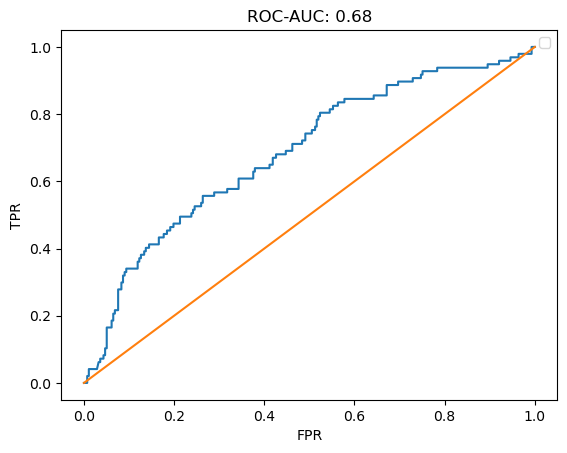

In [431]:
fpr, tpr, thresholds = curves
plt.plot(fpr, tpr)
plt.plot((0,1), (0,1))
plt.title(f'ROC-AUC: {roc_auc[0]:.2f}')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

random permutations of the labels

In [436]:
thresholds=[28,32,37]
X = scaler.fit_transform(embeddings_dHCP)

dict_AUC = {}

with open(save_dir+'/SVC_random_permutations.txt', 'w') as f:
    for threshold in thresholds:
        Y = (df_dhcp['birth_age']<threshold)
        auc_list = []
        for iter in range(100): # Faudrait-il faire 10 iter par échantillon ? Et prendre le max et comparer au max des 10 iter avec vrais labels ?
            Y_ = Y.sample(frac=1)
            model = SVC(kernel='linear', probability=True,
                    max_iter=-1, random_state=iter,
                    C=0.01, class_weight='balanced')
            labels_proba = cross_val_predict(model, X, Y_, cv=5, method='predict_proba')
            curves, roc_auc, accuracy = compute_indicators(Y_, labels_proba)
            auc_list.append(roc_auc)
        roc_auc = (np.mean(auc_list), 2*np.std(auc_list))
        thresh_95 = np.percentile(auc_list, 95)
        dict_AUC[str(threshold)]={'AUC': roc_auc[0], 'std': np.std(auc_list), '95th percentile': thresh_95}
        line = f'AUC {threshold} : {roc_auc[0]:.3f}, {roc_auc[1]:.3f}, 95th percentile: {thresh_95}'
        print(line)
        f.write(line)
        f.write('\n')
df_AUC = pd.DataFrame(dict_AUC)
df_AUC.to_csv(save_dir+'SVC_random_permutations.csv')

AUC 28 : 0.494, 0.186, 95th percentile: 0.6442920681986657
AUC 32 : 0.495, 0.108, 95th percentile: 0.5882407407407406
AUC 37 : 0.505, 0.086, 95th percentile: 0.565984964085005


# Top-predicted full-terms

In [275]:
X = scaler.fit_transform(embeddings_dHCP)
Y = df_dhcp['birth_age']<28

# train 100 models to get average predictions
labels_proba_list = []
for iter in range(100):
    model = SVC(kernel='linear', probability=True,
            max_iter=-1, random_state=iter,
            C=0.01, class_weight='balanced')
    labels_proba = cross_val_predict(model, X, Y, cv=5, method='predict_proba')
    labels_proba_list.append(labels_proba)

labels_proba = np.mean(labels_proba_list, axis=0)[:, 0]

df_predictions = info_dHCP[['sub', 'birth_age']]
df_predictions['preds']=labels_proba
df_predictions.sort_values('preds', inplace=True)

TN = df_predictions['sub'].tolist()[-18:] #beware to select only full-terms
print(TN)

['CC00843XX19', 'CC00367XX13', 'CC00669XX18', 'CC00593XX17', 'CC01014XX08', 'CC00204XX06', 'CC00816XX16', 'CC00714XX13', 'CC00289XX18', 'CC00348XX19', 'CC00352XX06', 'CC00568XX16', 'CC00325XX12', 'CC00304XX07', 'CC01077XX14', 'CC00765XX15', 'CC00569XX17', 'CC00564XX12']


<ipython-input-275-a50610452f9f>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_predictions['preds']=labels_proba
/usr/lib/python3/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [276]:
# same but extremely preterm vs full-term only
thresholds=[28,32,37]
X_ = scaler.fit_transform(embeddings_dHCP)

for threshold in thresholds:
    X = X_[df_dhcp.loc[(df_dhcp['birth_age']<threshold) | (df_dhcp['birth_age']>=37)].index.tolist()]
    Y = df_dhcp.loc[(df_dhcp['birth_age']<threshold) | (df_dhcp['birth_age']>=37)]['birth_age']<threshold
    auc_list = []
    for iter in range(10):
        model = SVC(kernel='linear', probability=True,
                max_iter=-1, random_state=iter,
                C=0.01, class_weight='balanced')
        labels_proba = cross_val_predict(model, X, Y, cv=5, method='predict_proba')
        curves, roc_auc, accuracy = compute_indicators(Y, labels_proba)
        auc_list.append(roc_auc)
    roc_auc = (np.mean(auc_list), 2*np.std(auc_list))
    line = f'AUC {threshold} : {roc_auc[0]:.3f}, {roc_auc[1]:.3f}'
    print(line)

AUC 28 : 0.762, 0.004
AUC 32 : 0.765, 0.007
AUC 37 : 0.765, 0.002


# SVC UKB / dHCP

In [277]:
# The UMAP suggests that dHCP is inside UKB: but is the latent space really included ?
# Compare UMAP and latent space AUCs.

# embeddings
df_embeddings_ukb = pd.read_csv(save_dir+'embeddings_ukb.csv')
df_embeddings_dHCP = pd.read_csv(save_dir+'embeddings_dHCP.csv')
dims = [f'dim{k}' for k in range(1, 11)]

X1 = df_embeddings_dHCP[dims]
X2 = df_embeddings_ukb[dims]
X = np.vstack((X1, X2))
Y = np.array([1 for k in range(len(X1))] + [0 for k in range(len(X2))])

model = SVC(kernel='linear', probability=True,
                    max_iter=-1, random_state=5,
                    C=0.01, class_weight='balanced')

labels_proba = cross_val_predict(model, X, Y, cv=5, method='predict_proba')

labels_true = Y.astype('float64')
curves = roc_curve(labels_true, labels_proba[:, 1])
roc_auc = roc_auc_score(labels_true, labels_proba[:, 1])
partial_auc_005 = roc_auc_score(labels_true, labels_proba[:, 1], max_fpr=0.05)
partial_auc_01 = roc_auc_score(labels_true, labels_proba[:, 1], max_fpr=0.1)

In [385]:
# with SimCLR STS right
#df_embeddings_dHCP = pd.read_csv('/neurospin/dico/jlaval/Runs/02_STS_babies/Program/Output/2023-11-29/15-49-36_0/dHCP_embeddings/full_embeddings.csv')
#df_embeddings_ukb = pd.read_csv('/neurospin/dico/jlaval/Runs/02_STS_babies/Program/Output/2023-11-29/15-49-36_0/UKB_embeddings/full_embeddings.csv')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


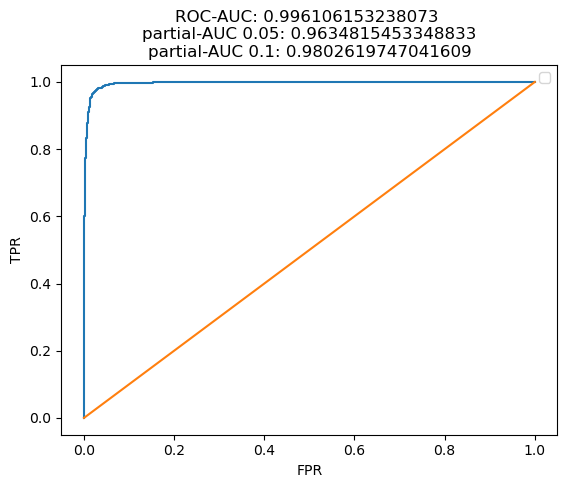

In [382]:
fpr, tpr, thresholds = curves
plt.plot(fpr, tpr)
plt.plot((0,1), (0,1))
plt.title(f'ROC-AUC: {roc_auc} \npartial-AUC 0.05: {partial_auc_005}\npartial-AUC 0.1: {partial_auc_01}')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.savefig(save_dir+'/AUC_dHCP_vs_UKB.png', facecolor='white')
plt.show()

In [383]:
# In UMAP space
reducer = umap.UMAP(random_state=3)
X2 = reducer.fit_transform(X2)
X1 = reducer.transform(X1)
X = np.vstack((X1, X2))

model = SVC(kernel='linear', probability=True,
                    max_iter=-1, random_state=5,
                    C=0.01, class_weight='balanced')

labels_proba = cross_val_predict(model, X, Y, cv=5, method='predict_proba')

labels_true = Y.astype('float64')
curves = roc_curve(labels_true, labels_proba[:, 1])
roc_auc = roc_auc_score(labels_true, labels_proba[:, 1])
partial_auc_005 = roc_auc_score(labels_true, labels_proba[:, 1], max_fpr=0.05)
partial_auc_01 = roc_auc_score(labels_true, labels_proba[:, 1], max_fpr=0.1)

/casa/home/.local/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


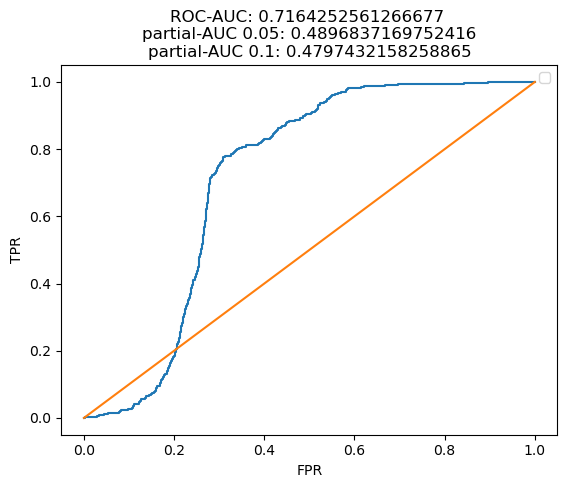

In [384]:
fpr, tpr, thresholds = curves
plt.plot(fpr, tpr)
plt.plot((0,1), (0,1))
plt.title(f'ROC-AUC: {roc_auc} \npartial-AUC 0.05: {partial_auc_005}\npartial-AUC 0.1: {partial_auc_01}')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.savefig(save_dir+'/AUC_dHCP_vs_UKB_UMAP_space.png', facecolor='white')
plt.show()

## Preterm Reconstruction Visualization

In [210]:
# match dHCP preterms with indexes
ordered_subjects = pd.read_csv('/neurospin/dico/data/deep_folding/current/datasets/dHCP_374_subjects/crops/2mm/S.T.s.baby/mask/Rskeleton_subject.csv')
ordered_subjects.columns=['sub']
info_dHCP_ordered = pd.merge(ordered_subjects, info_dHCP, on='sub')
preterms = info_dHCP_ordered[info_dHCP_ordered['birth_age'] < 28]['sub']

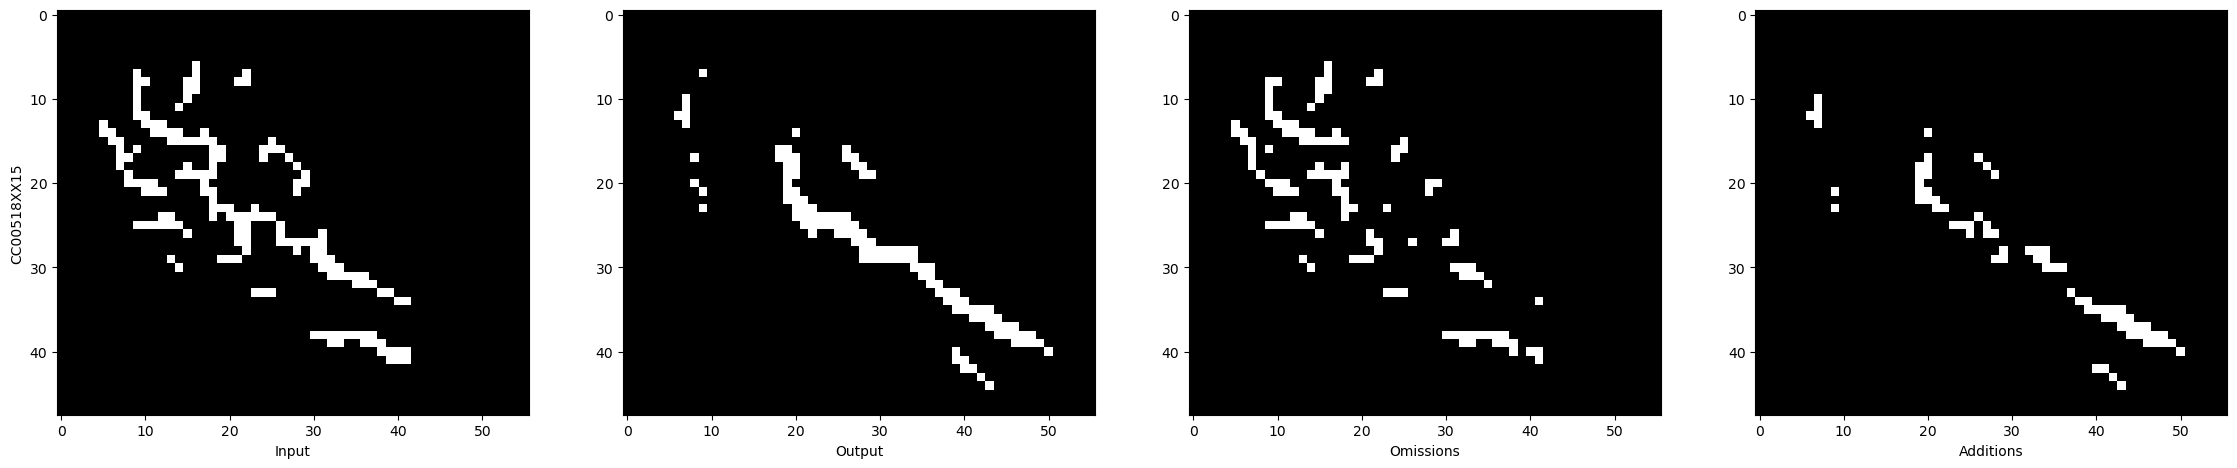

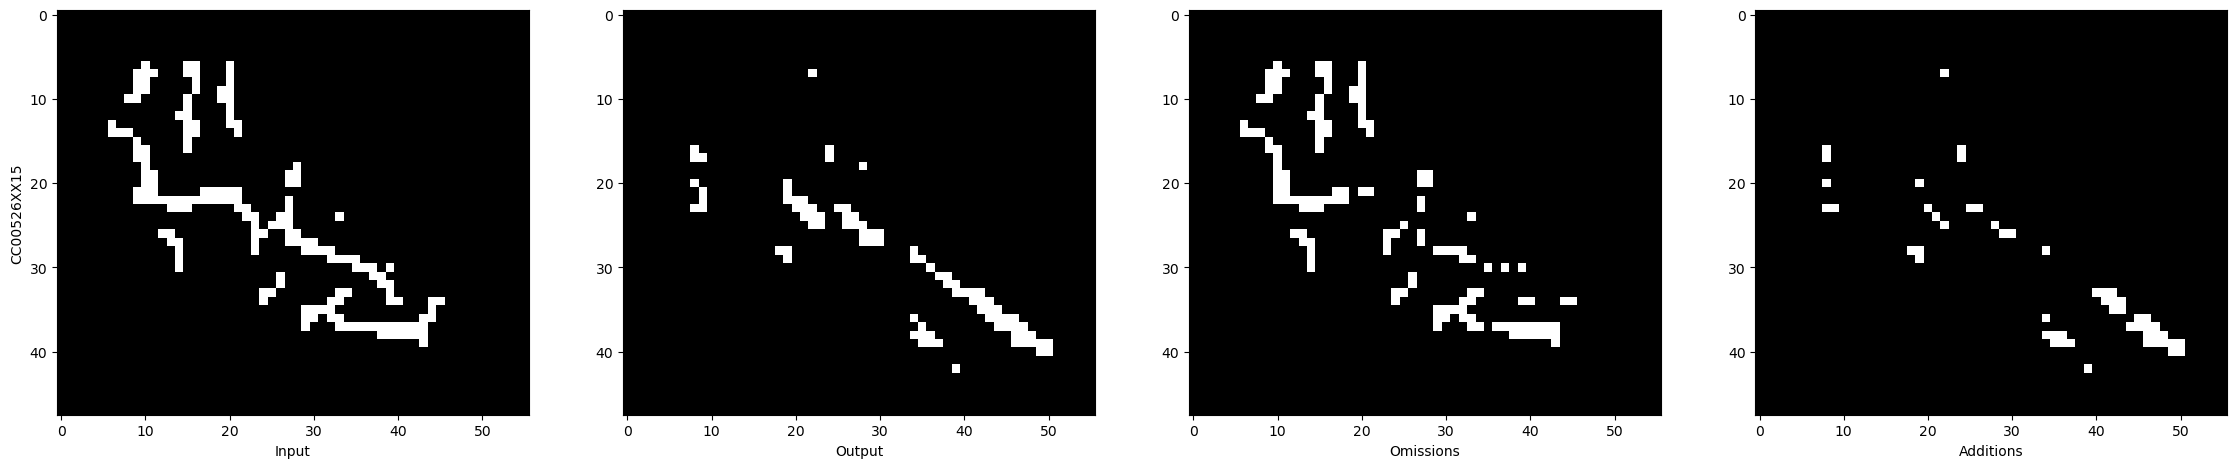

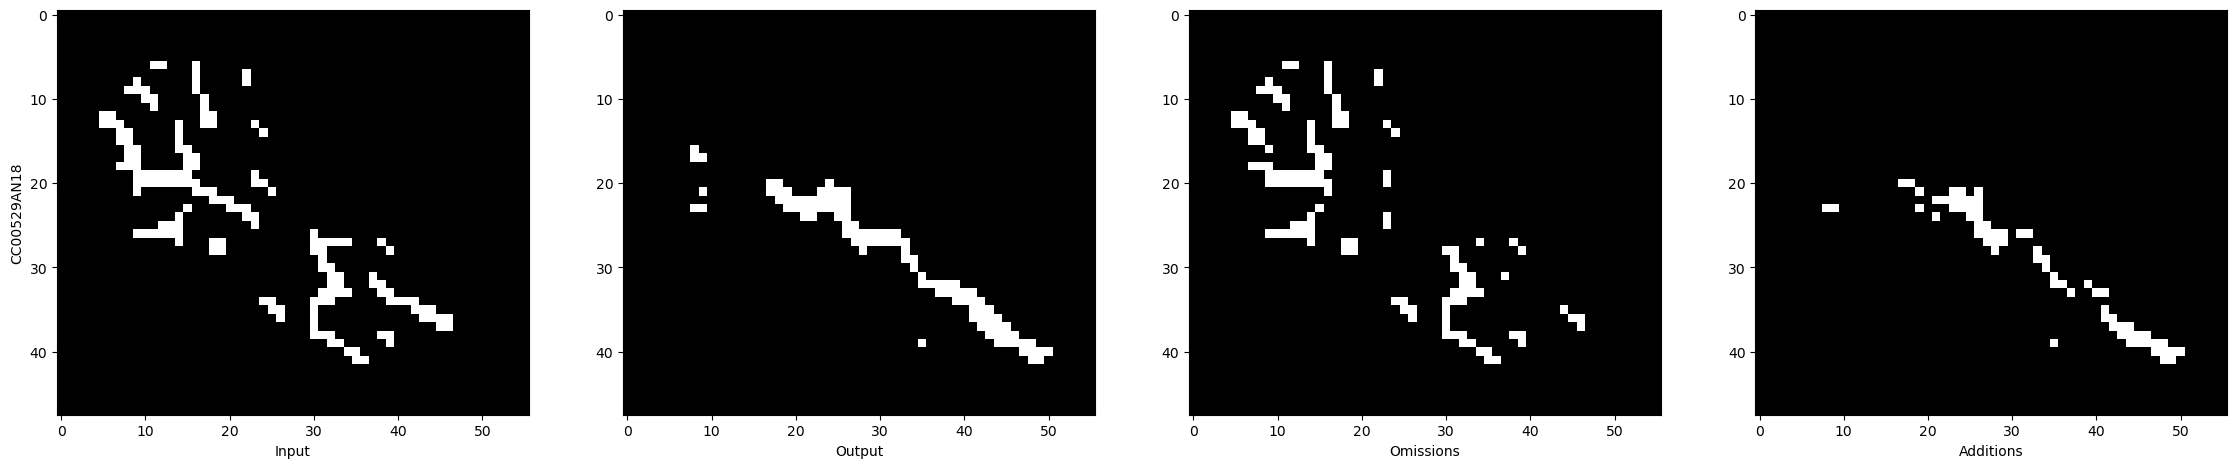

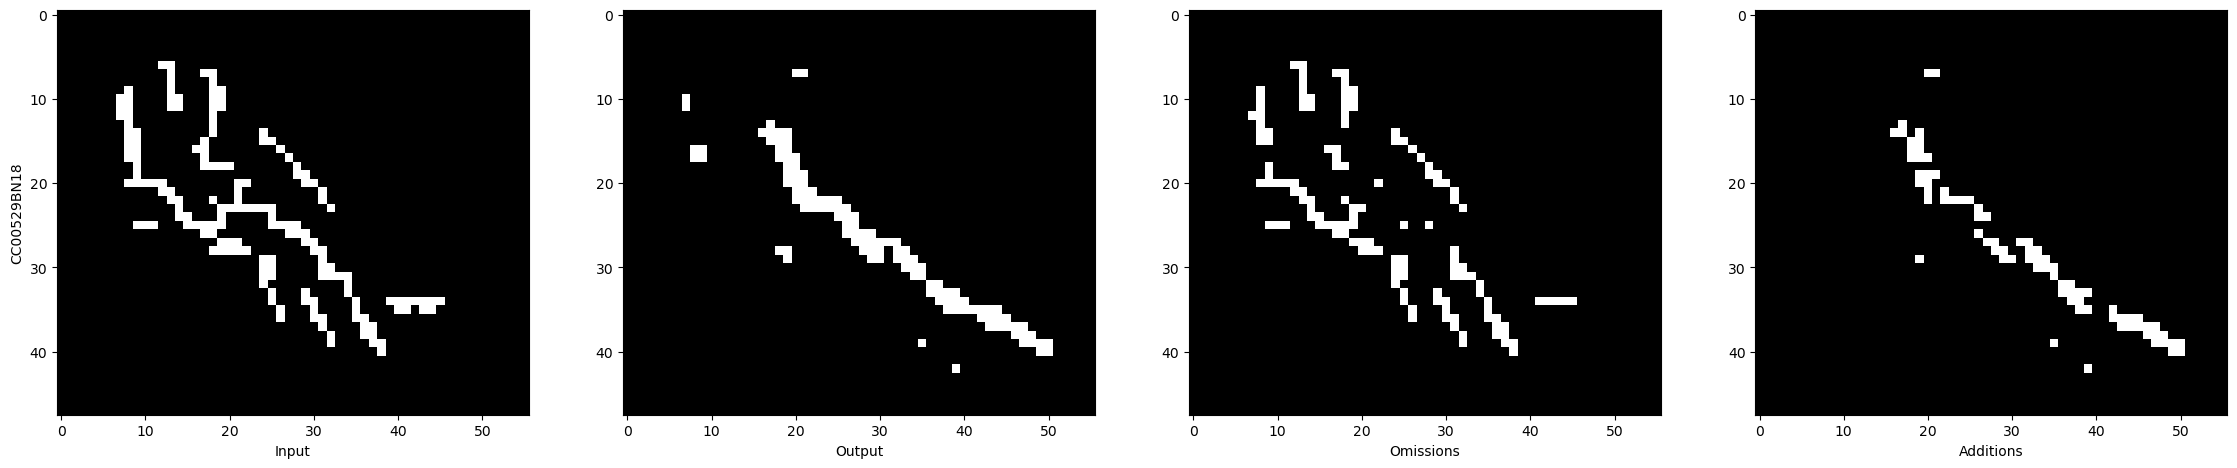

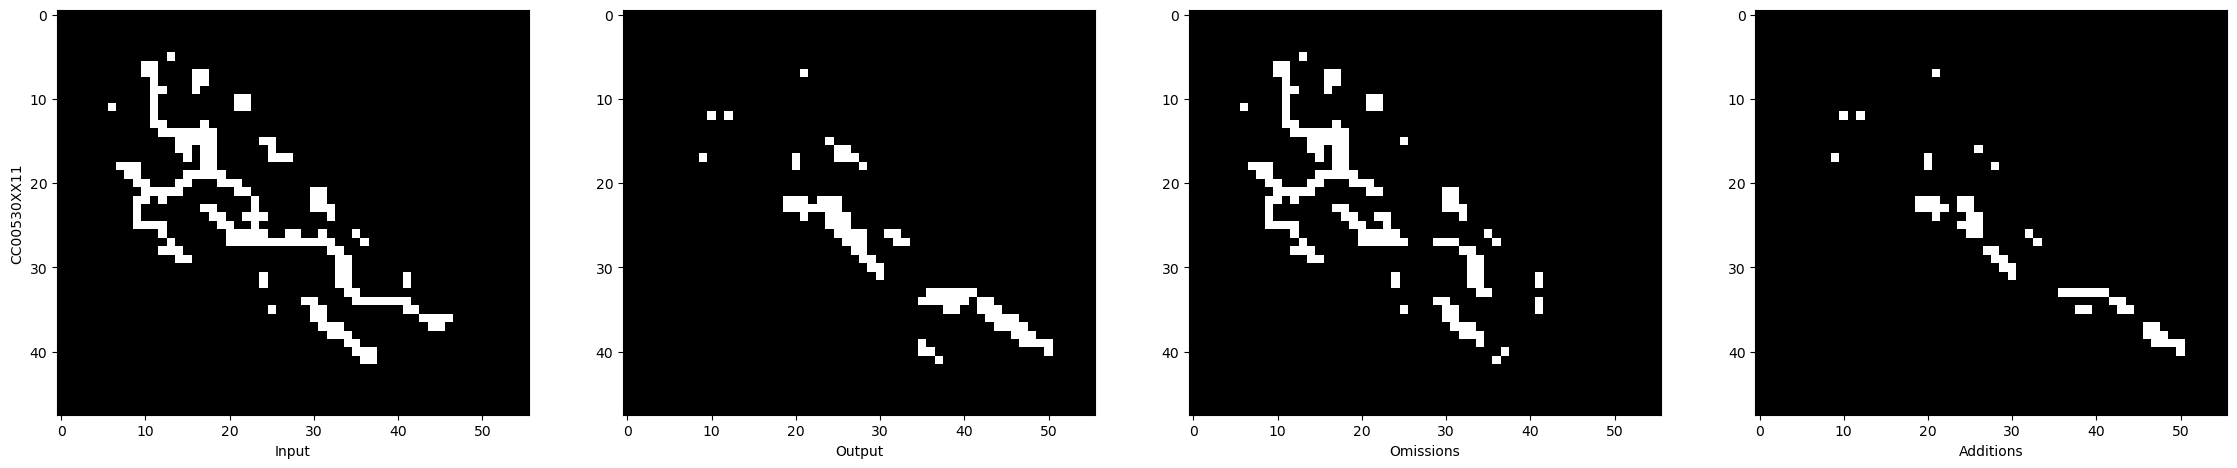

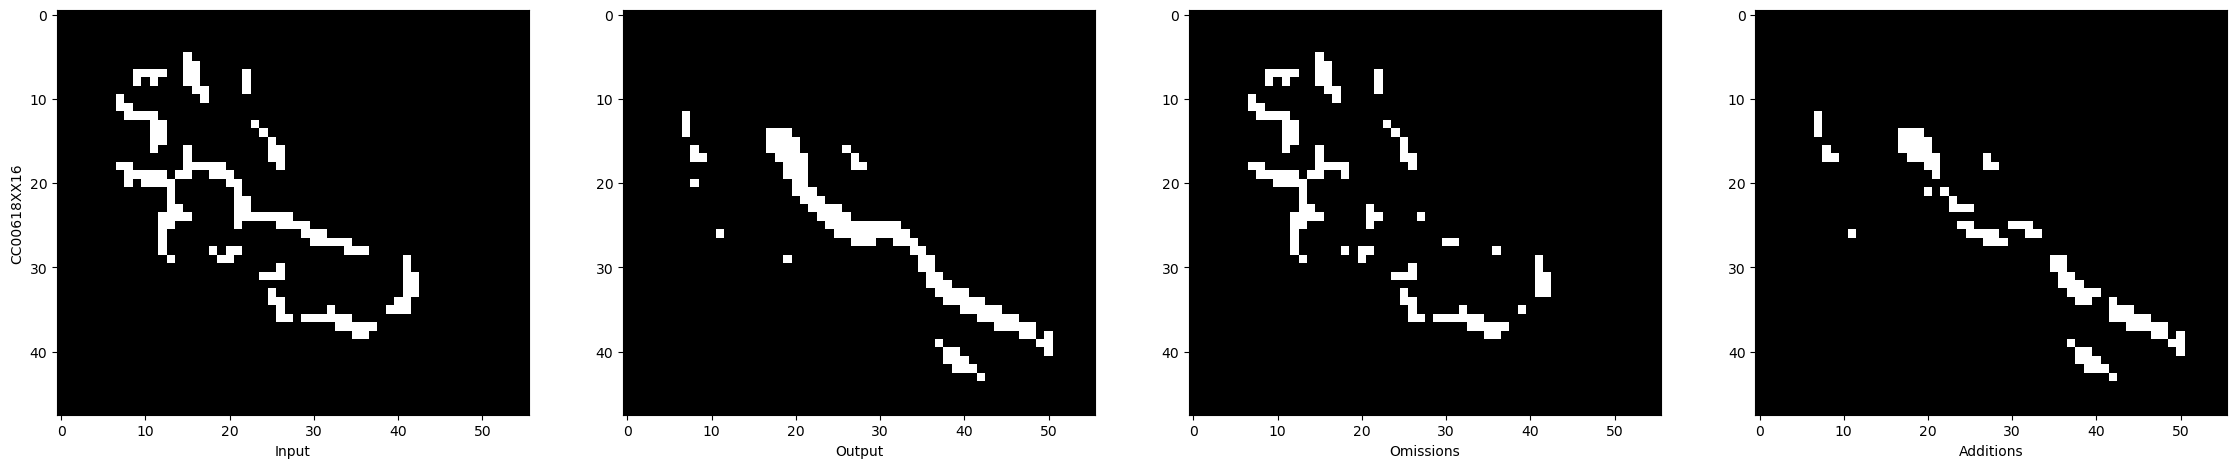

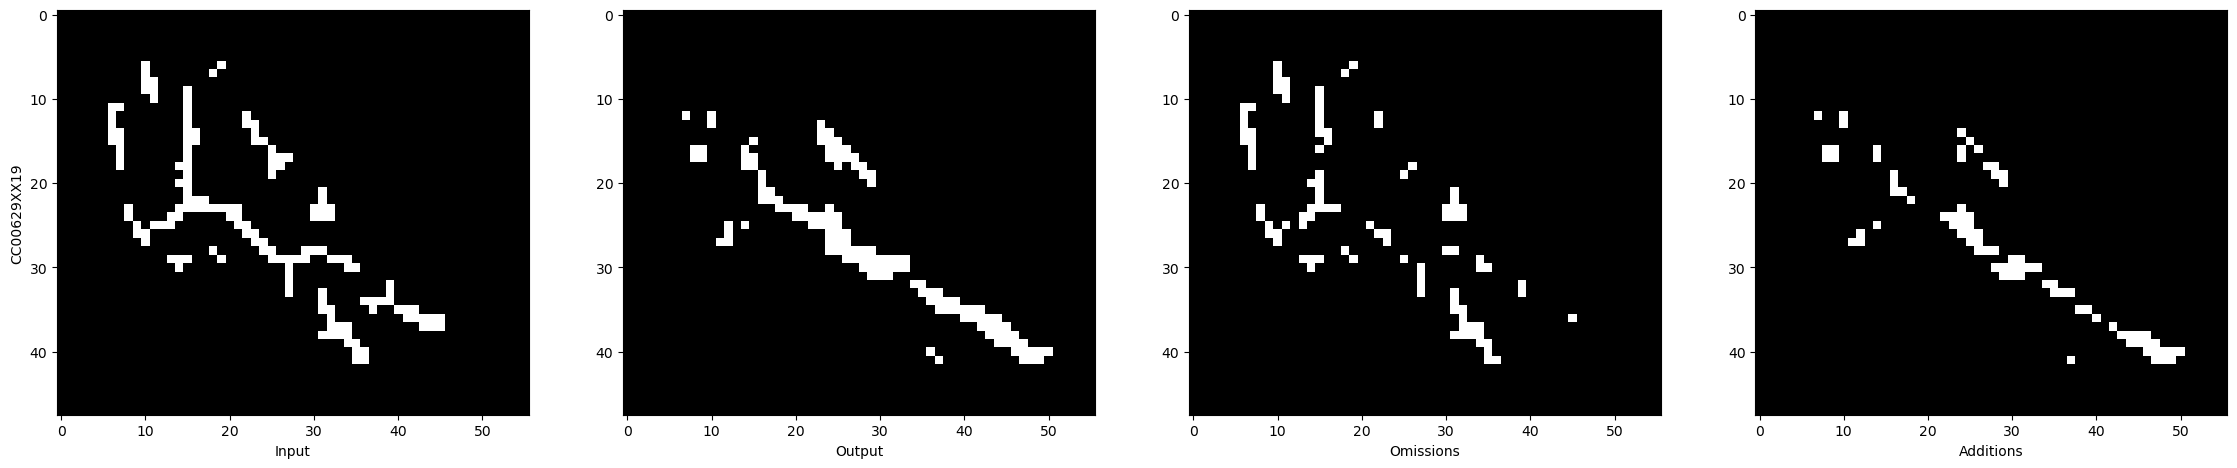

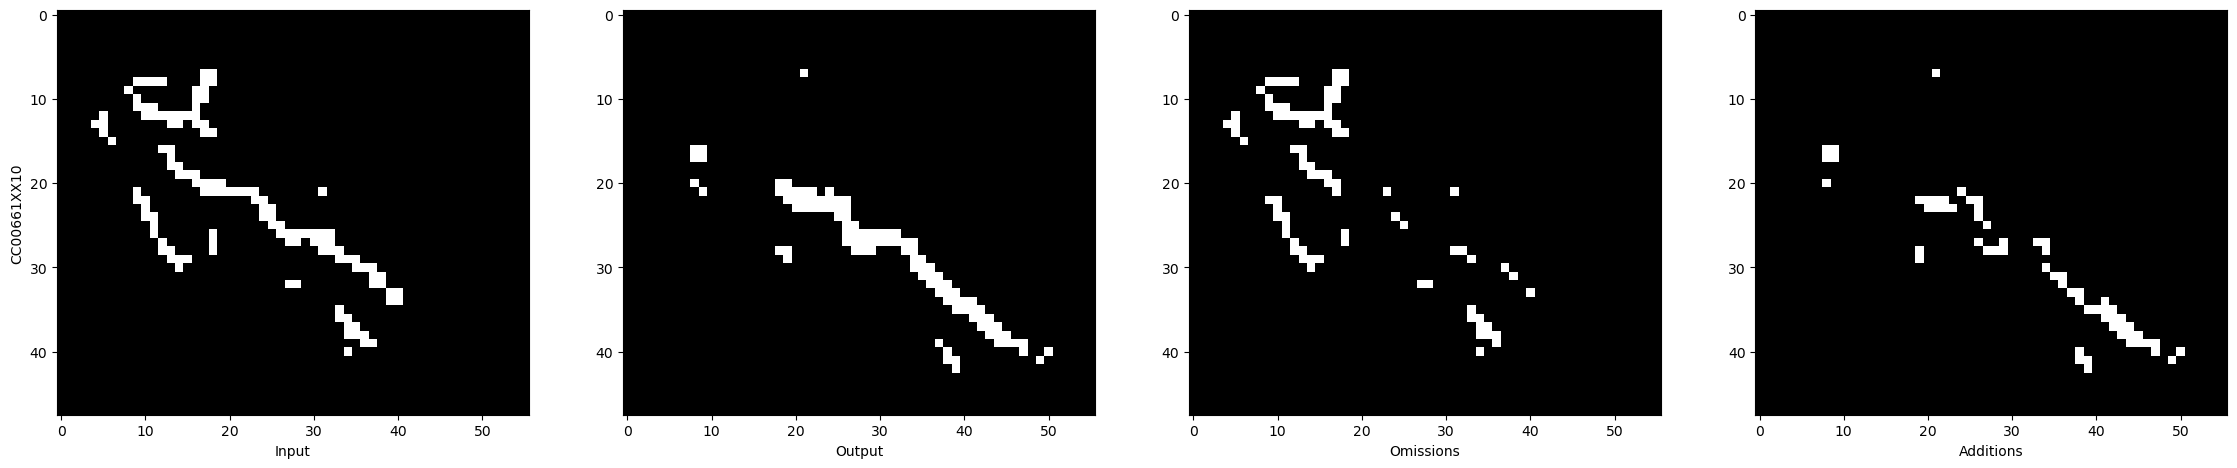

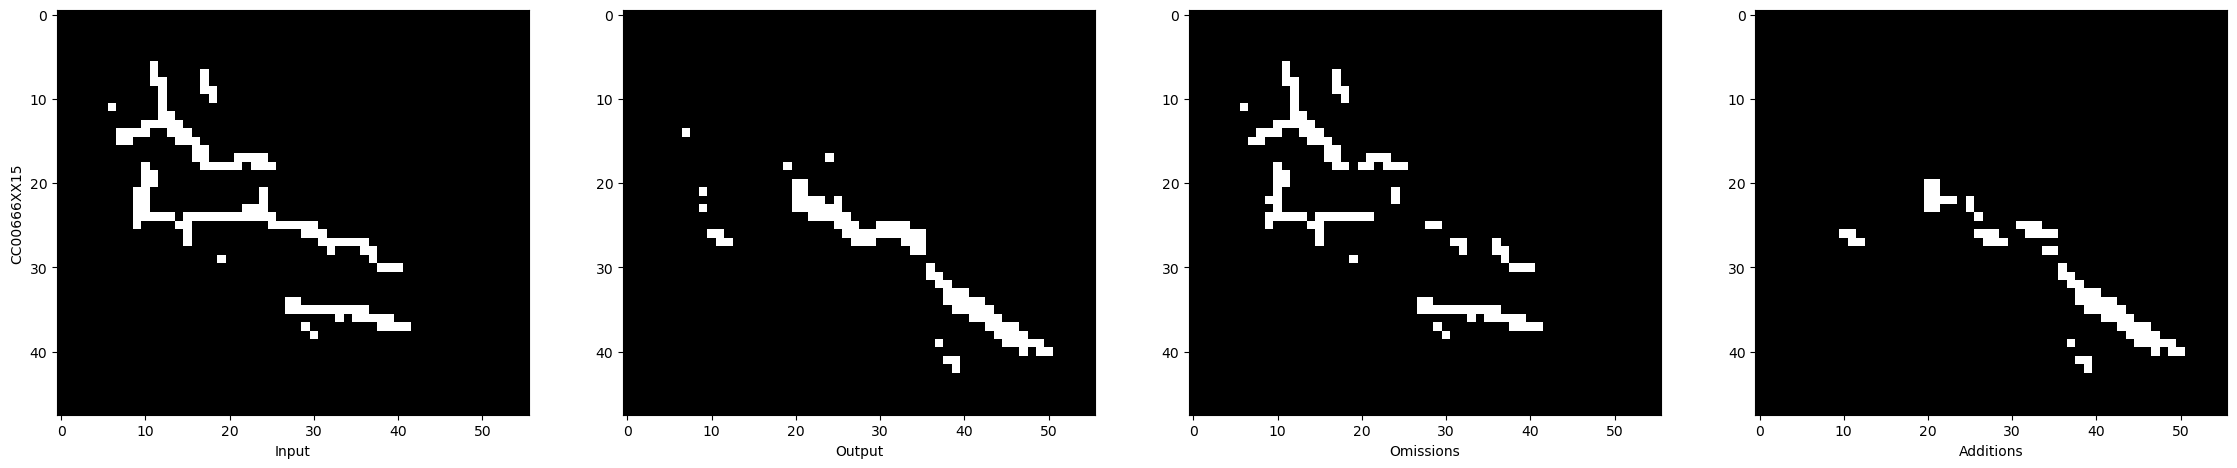

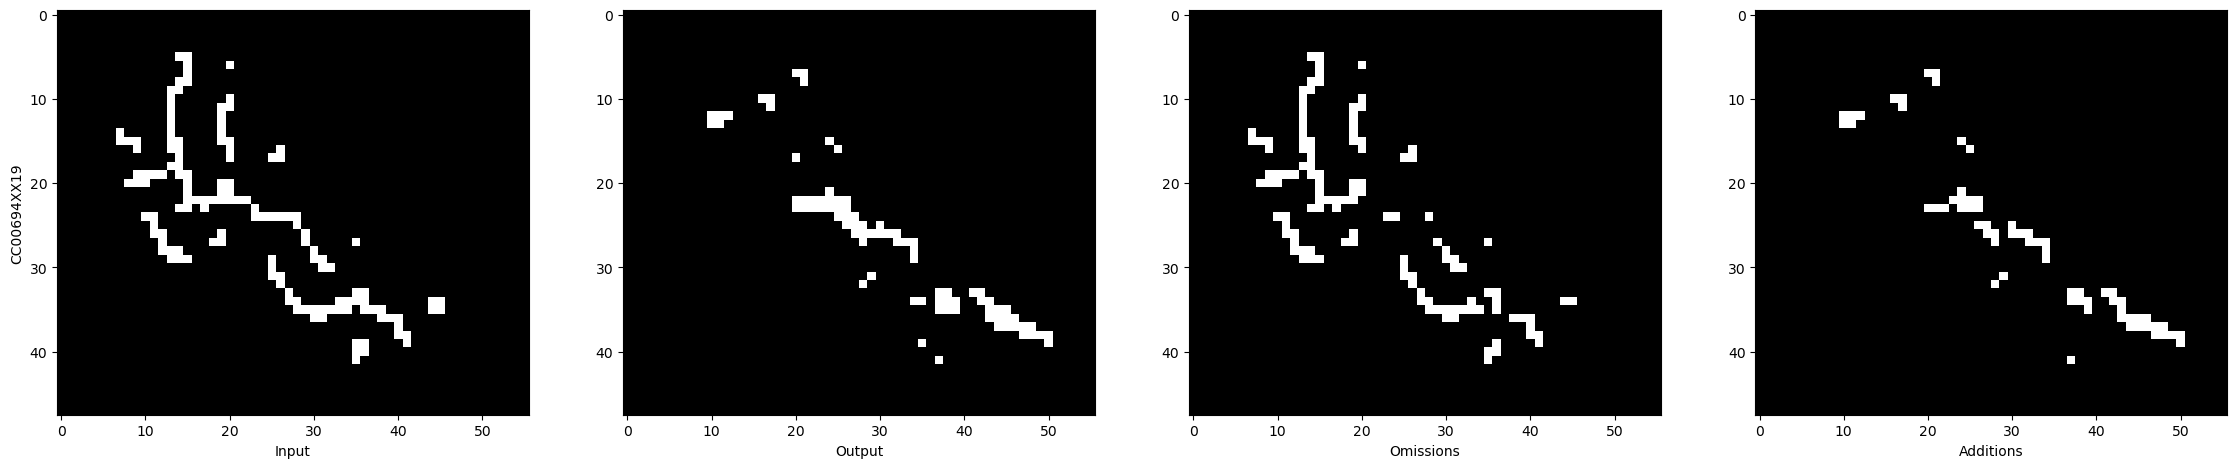

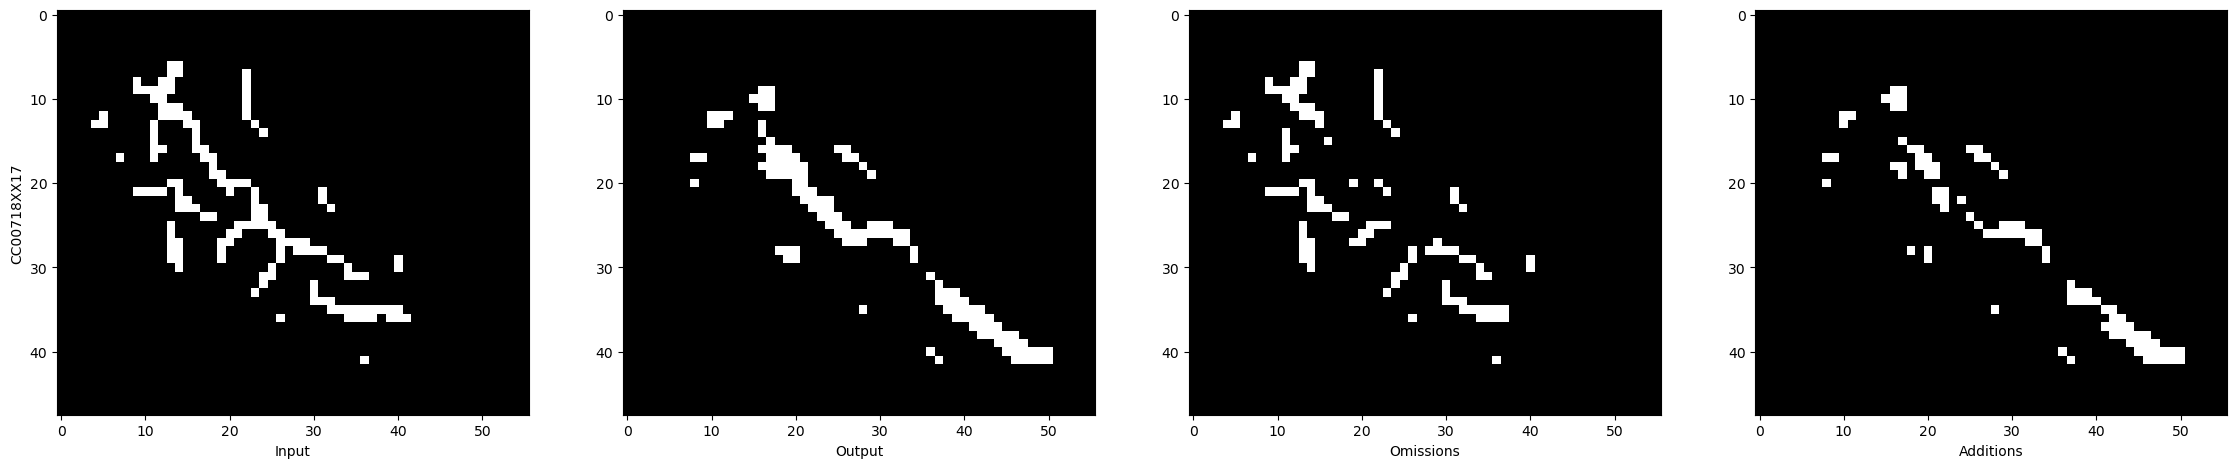

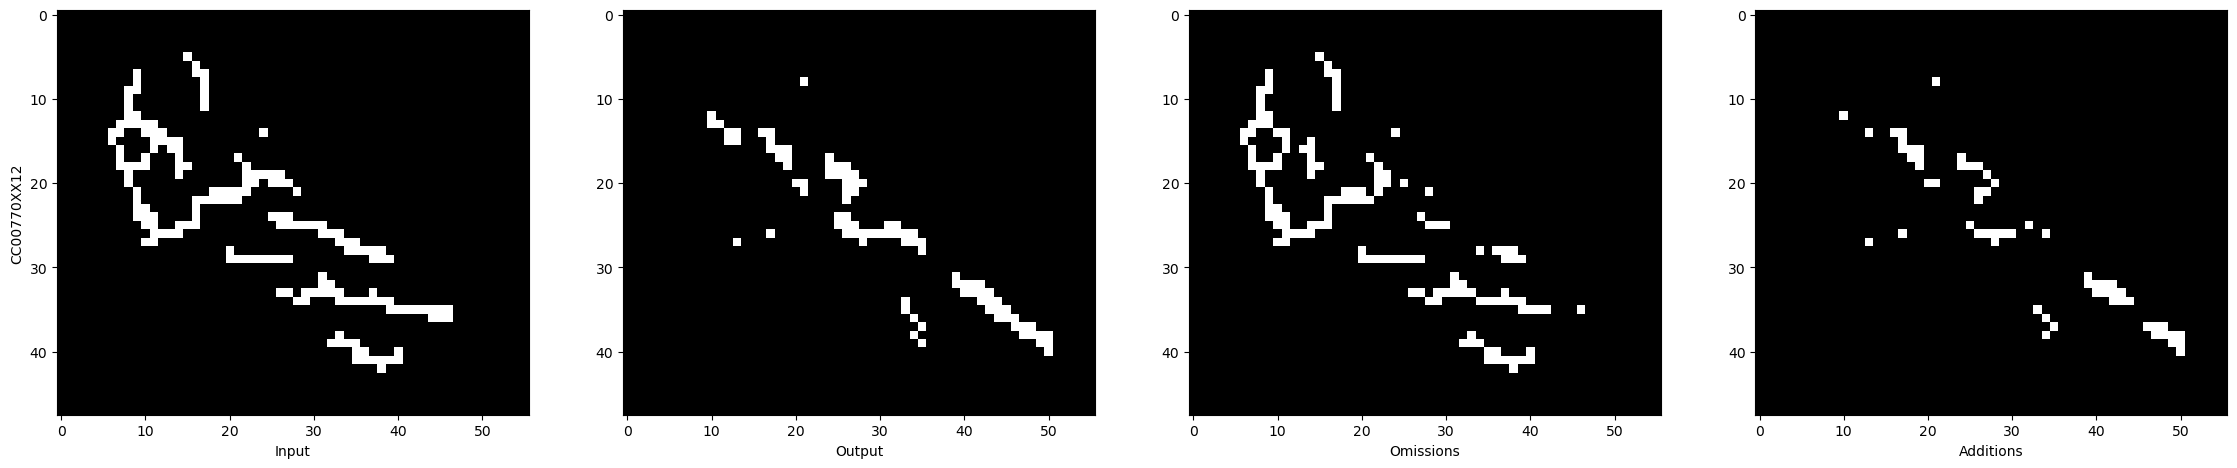

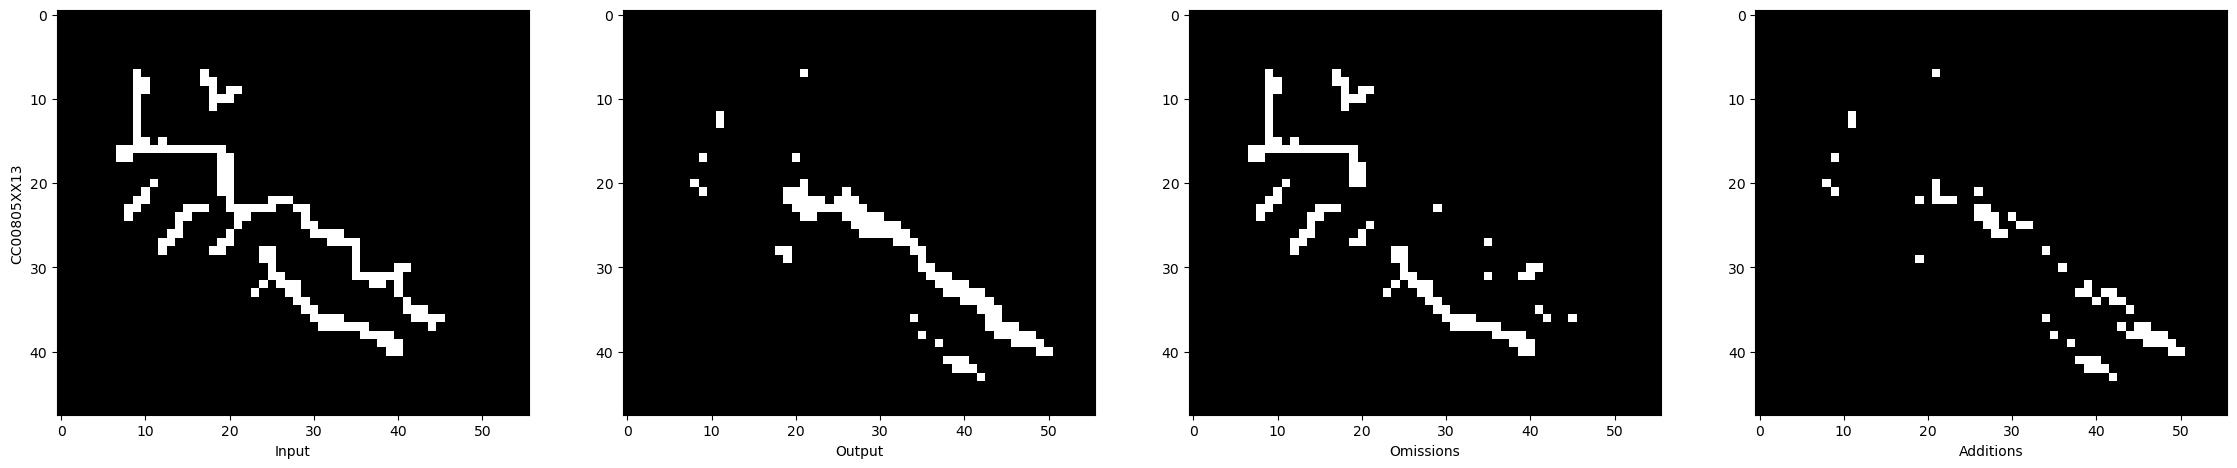

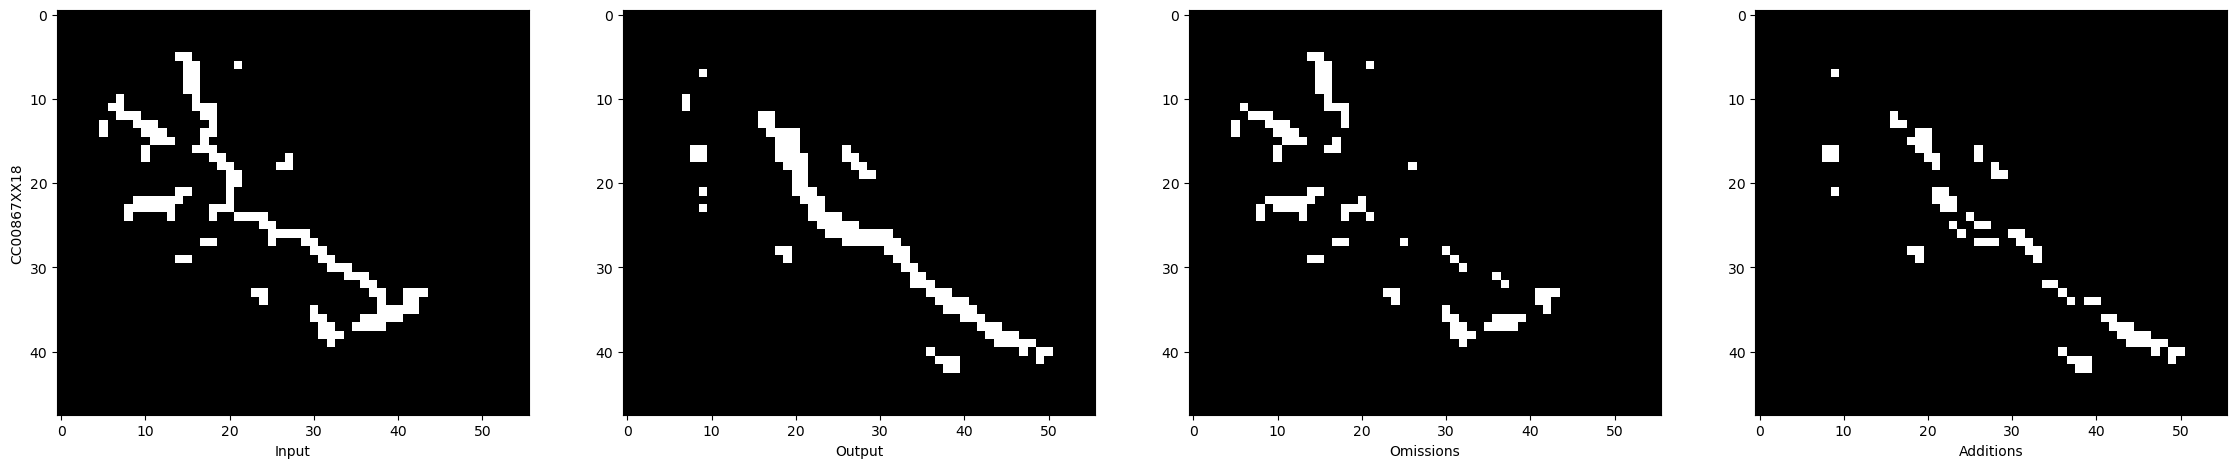

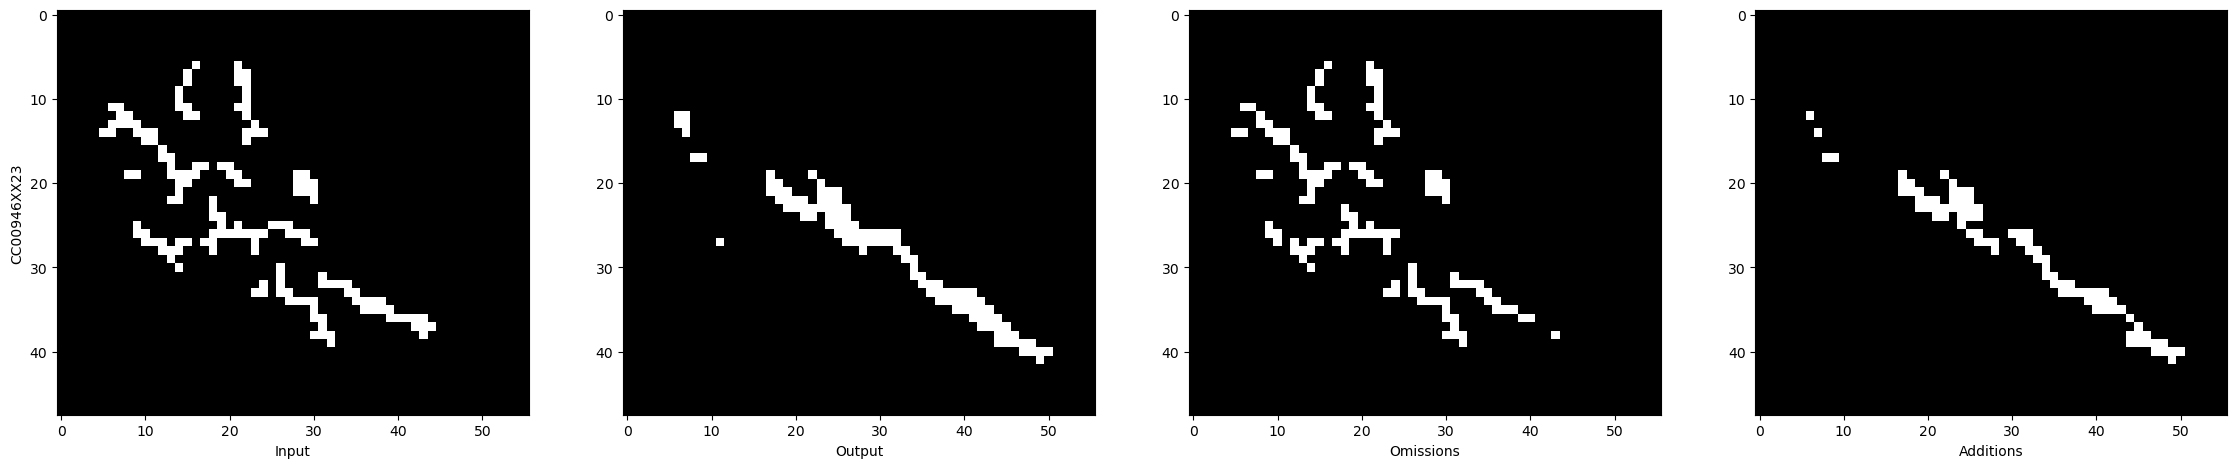

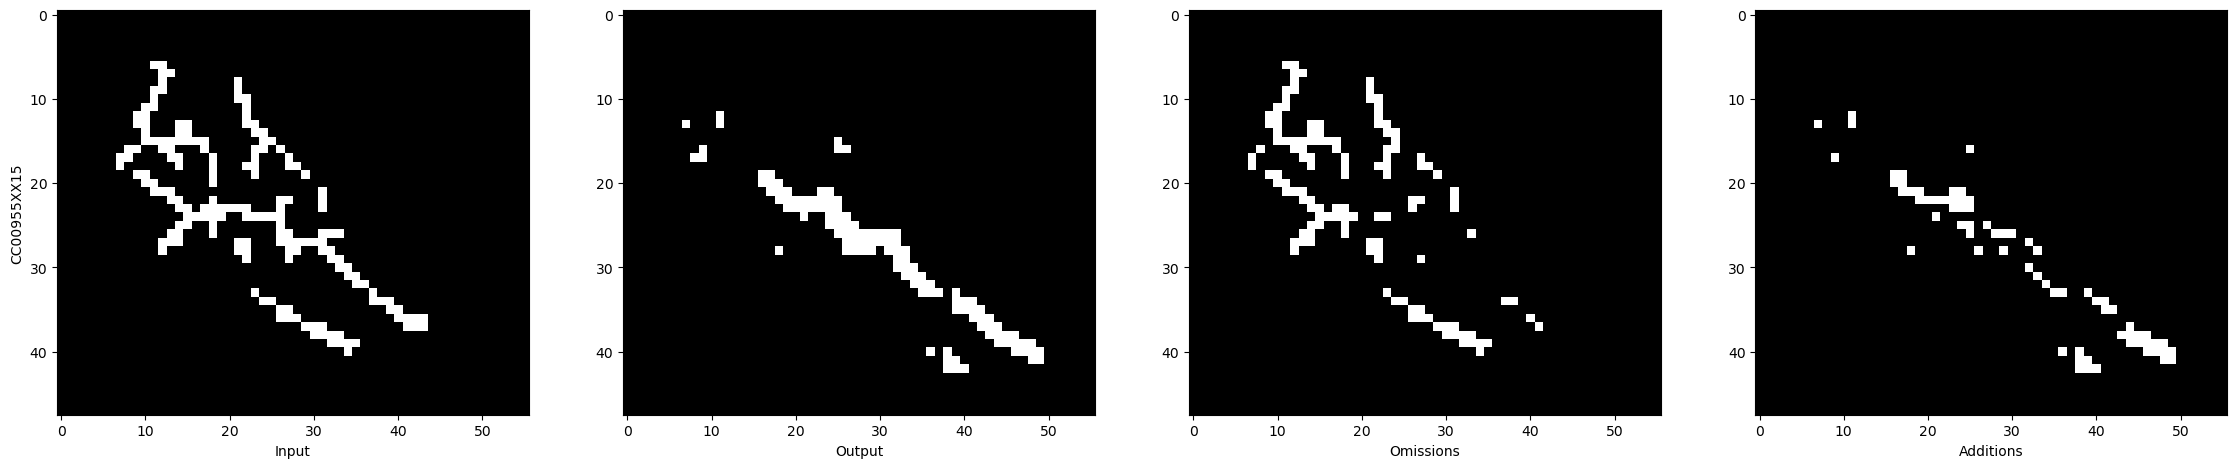

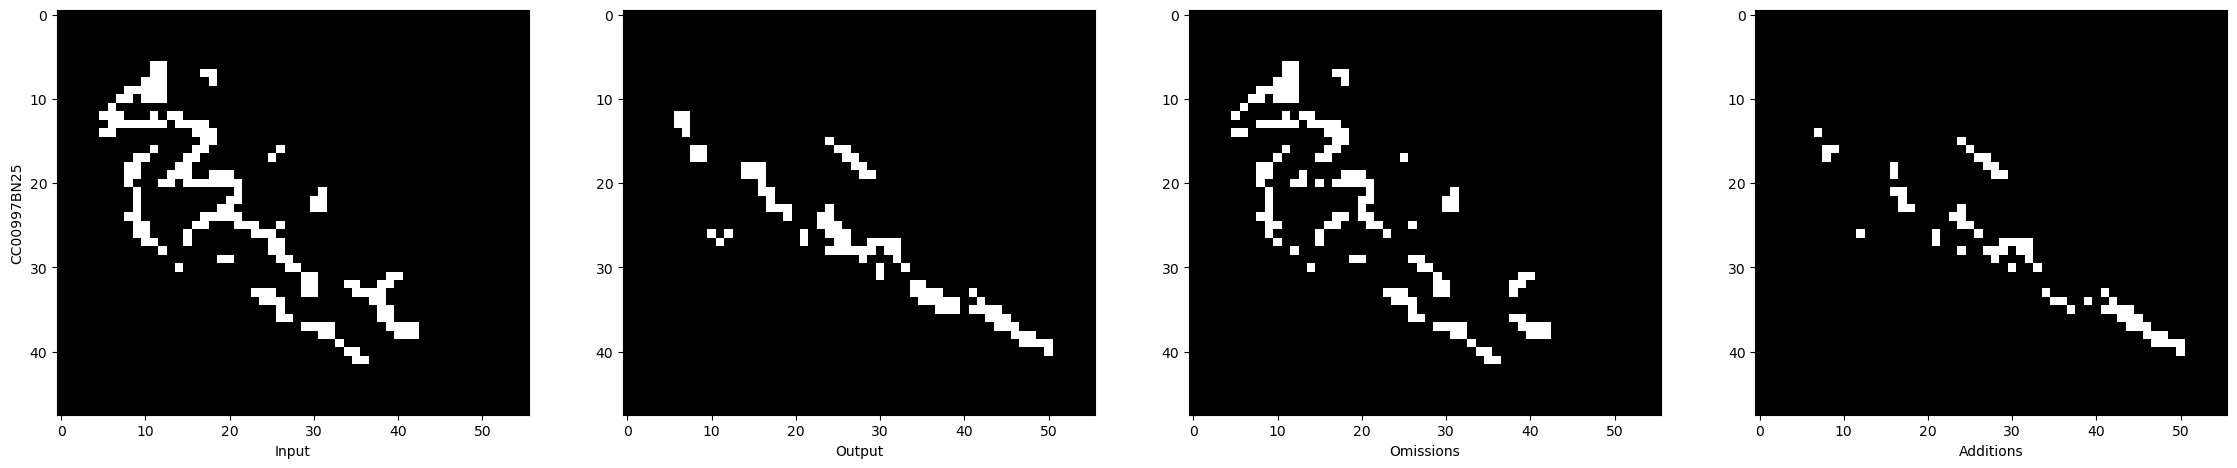

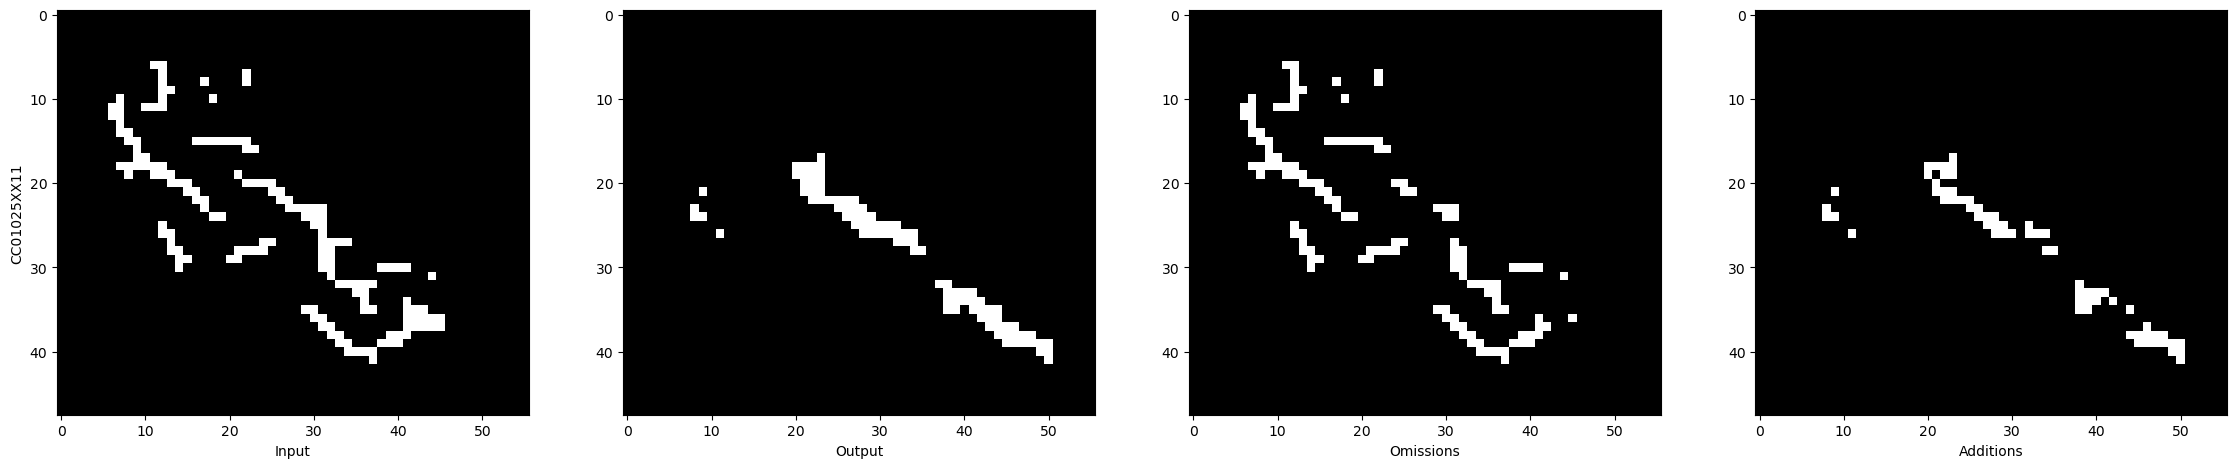

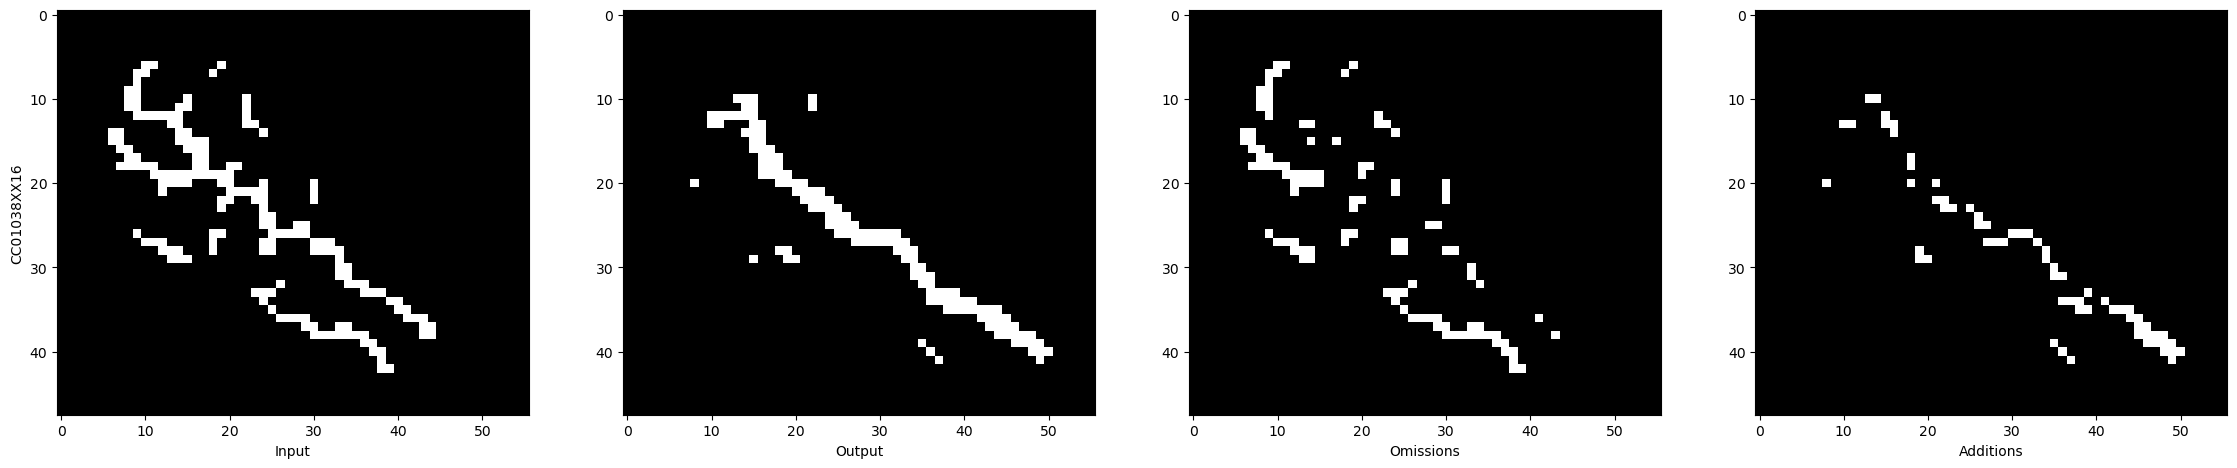

In [571]:
#dHCP preterms reconstructions

depth=16

for idx, subject in preterms.items():
    fig, axs = plt.subplots(ncols=4, figsize=(28,7))
    input = np.rot90(dHCP_skels[idx][depth,:,:], axes=(1, 0))
    output = np.rot90(dHCP_reconstructions[idx][depth,:,:], axes=(1,0))
    axs[0].imshow(input, cmap='gray')
    axs[0].set_xlabel('Input')
    axs[1].imshow(output, cmap='gray')
    axs[1].set_xlabel('Output')
    axs[2].imshow((input.astype(int)-output.astype(int)) == 1, cmap='gray')
    axs[2].set_xlabel('Omissions')
    axs[3].imshow((output.astype(int)-input.astype(int)) == 1, cmap='gray')
    axs[3].set_xlabel('Additions')
    axs[0].set_ylabel(subject)
    plt.savefig(save_dir+'Reconstructions'+'/Preterm/'+f'/Reconstruction_{subject}_no_sampling', facecolor='white')
plt.show()


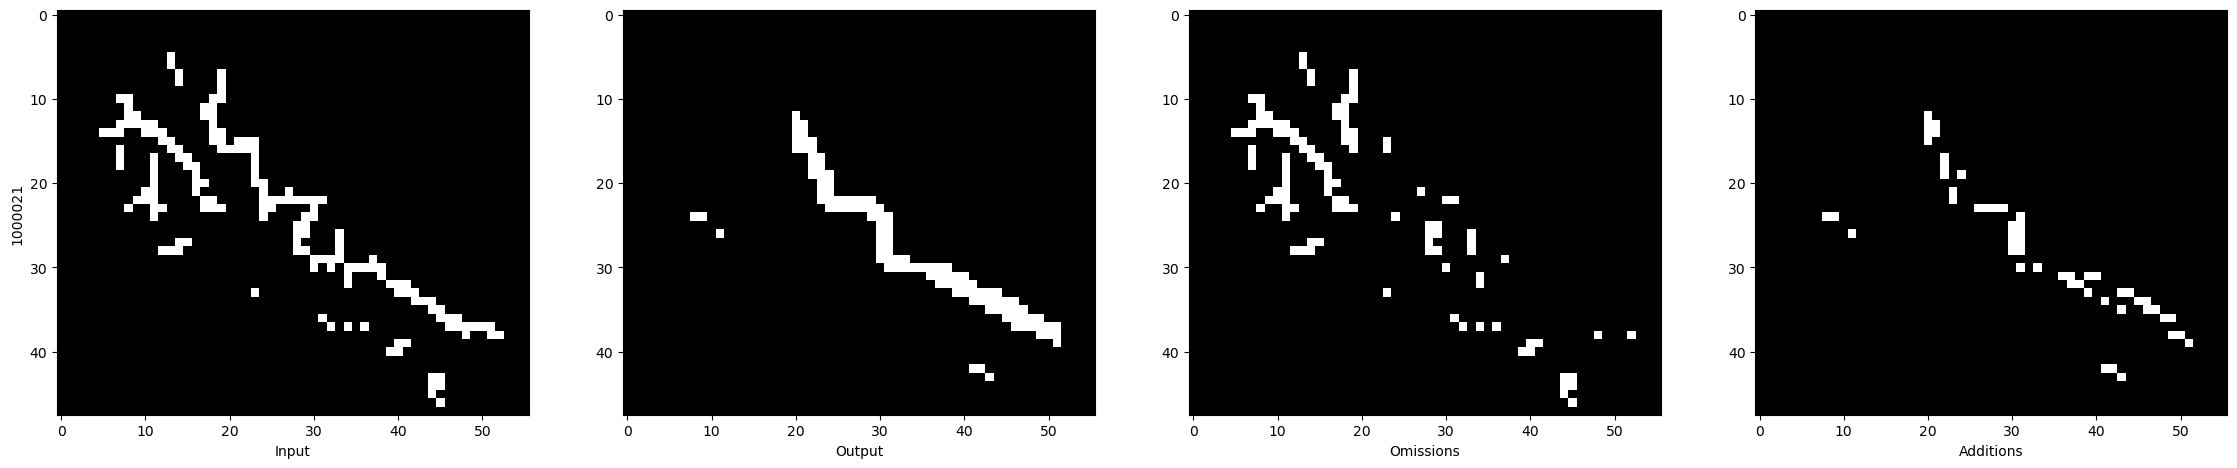

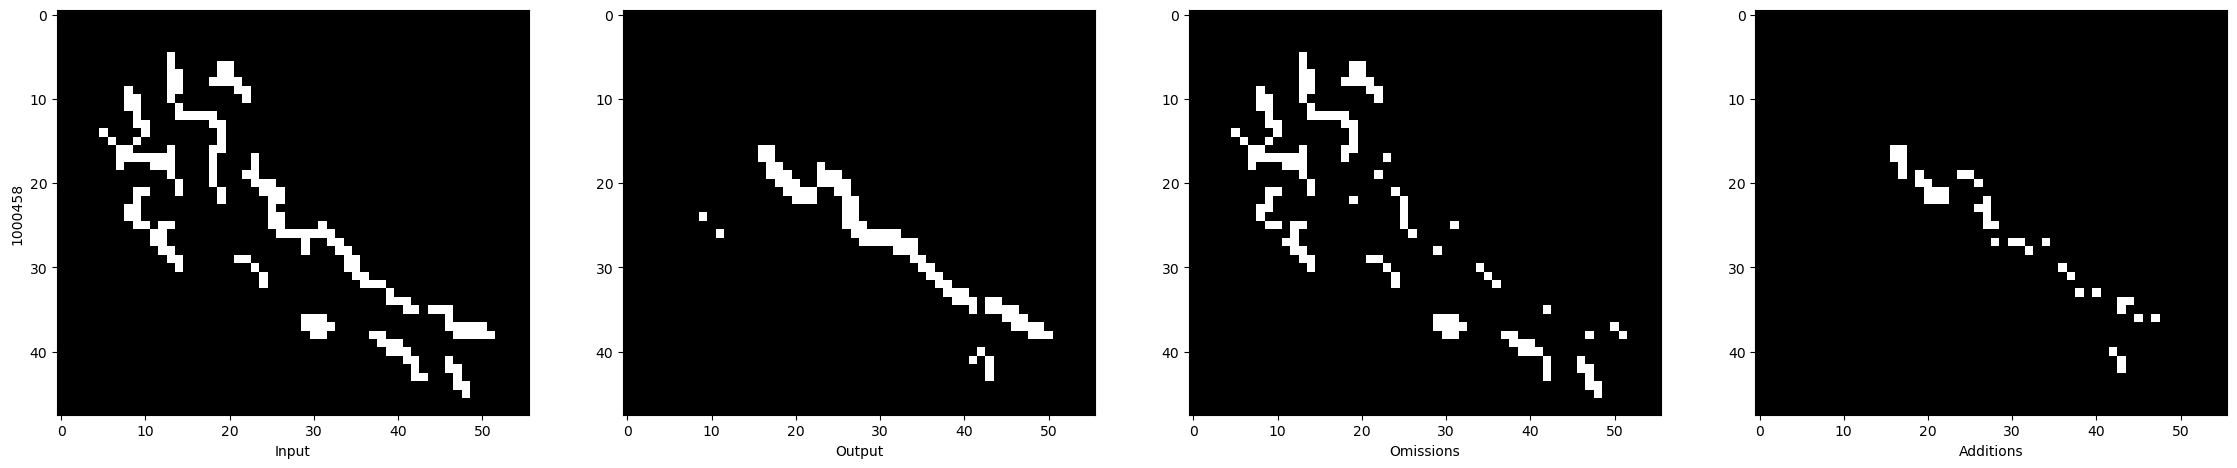

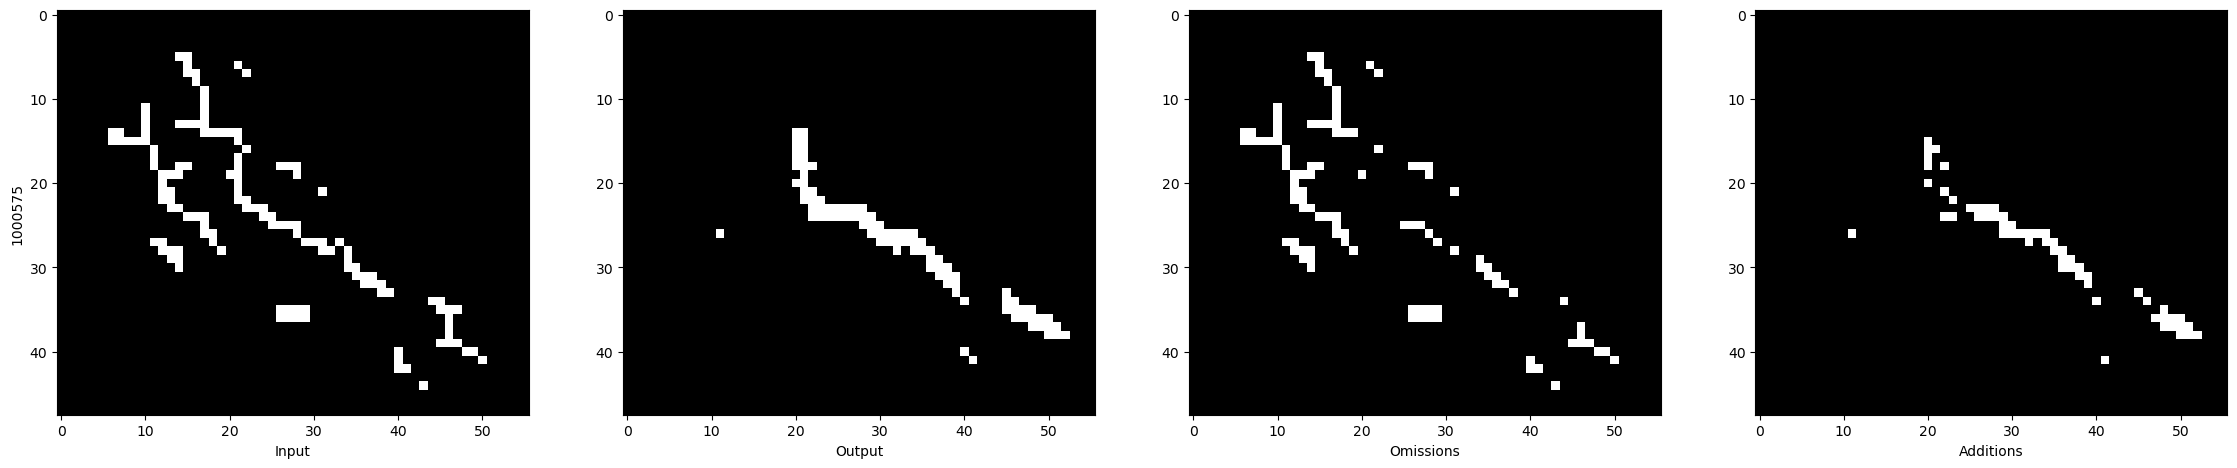

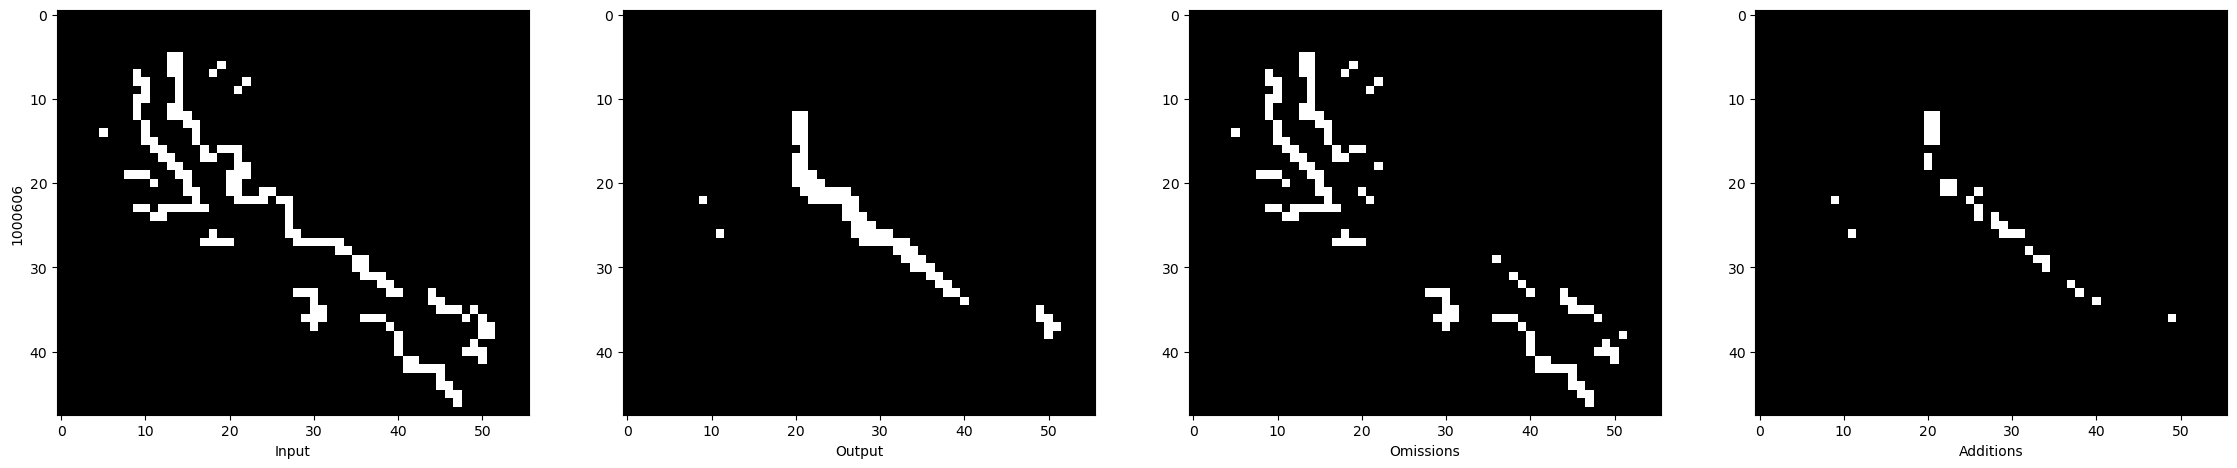

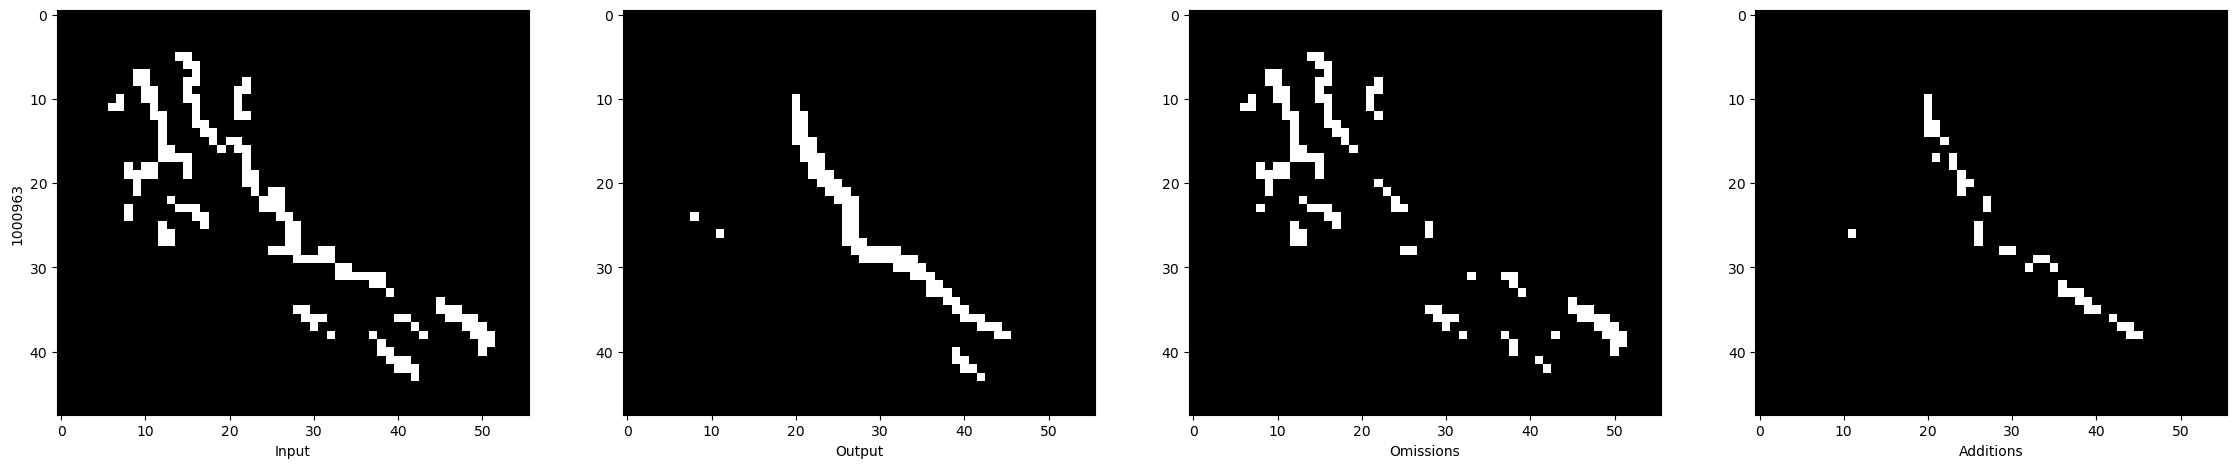

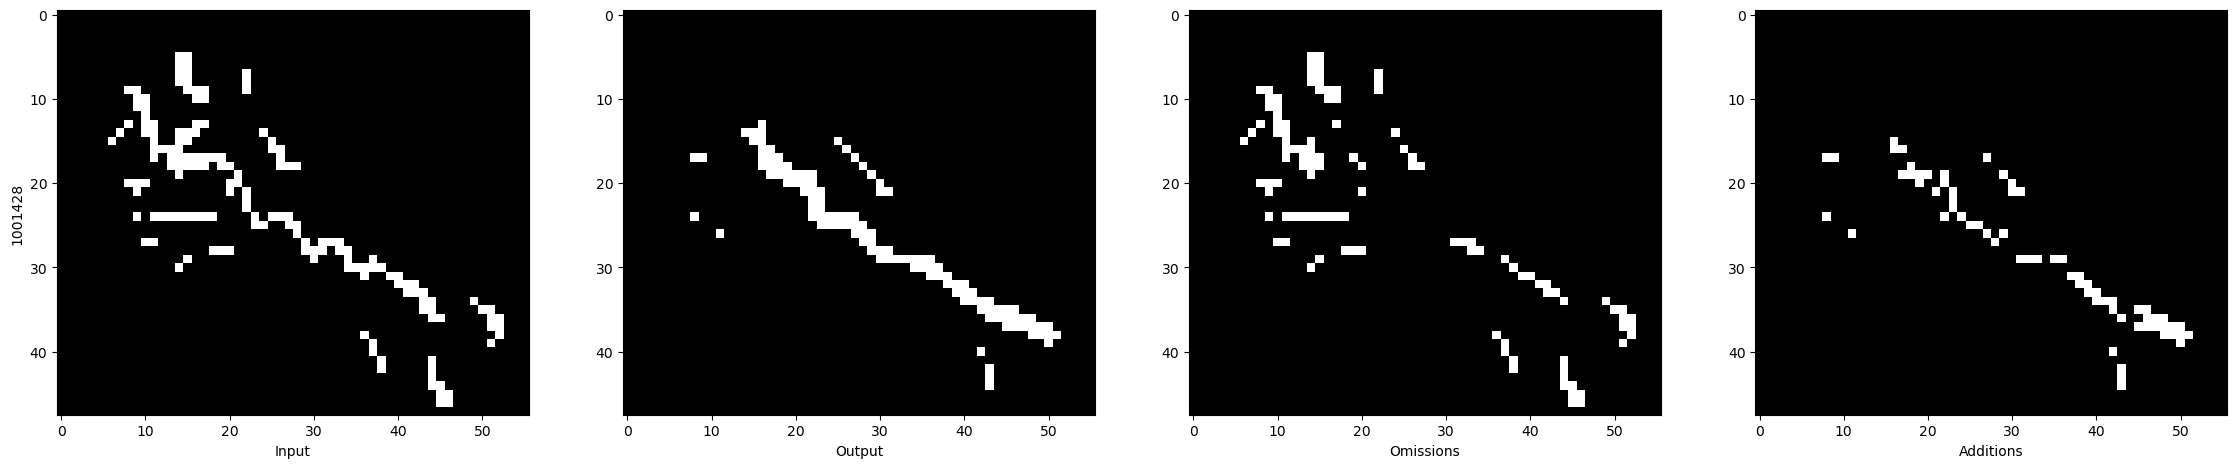

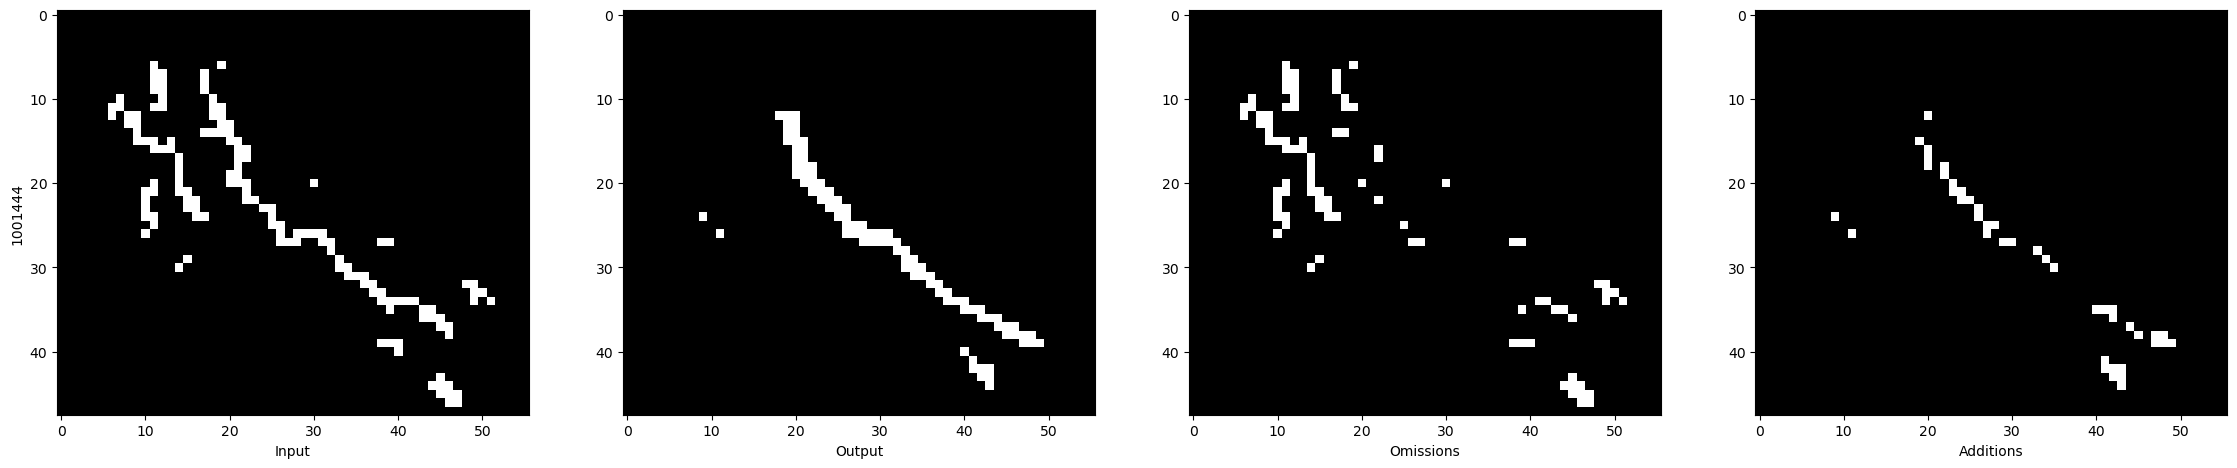

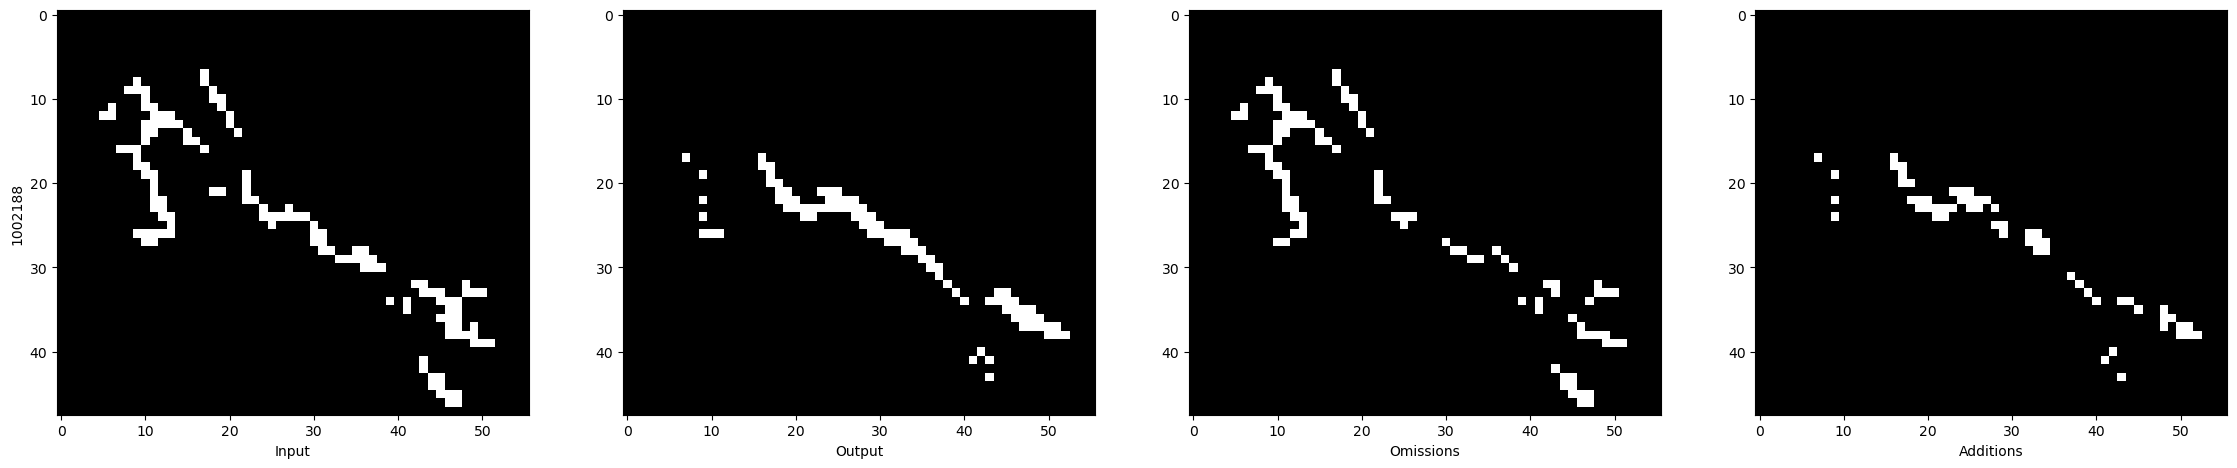

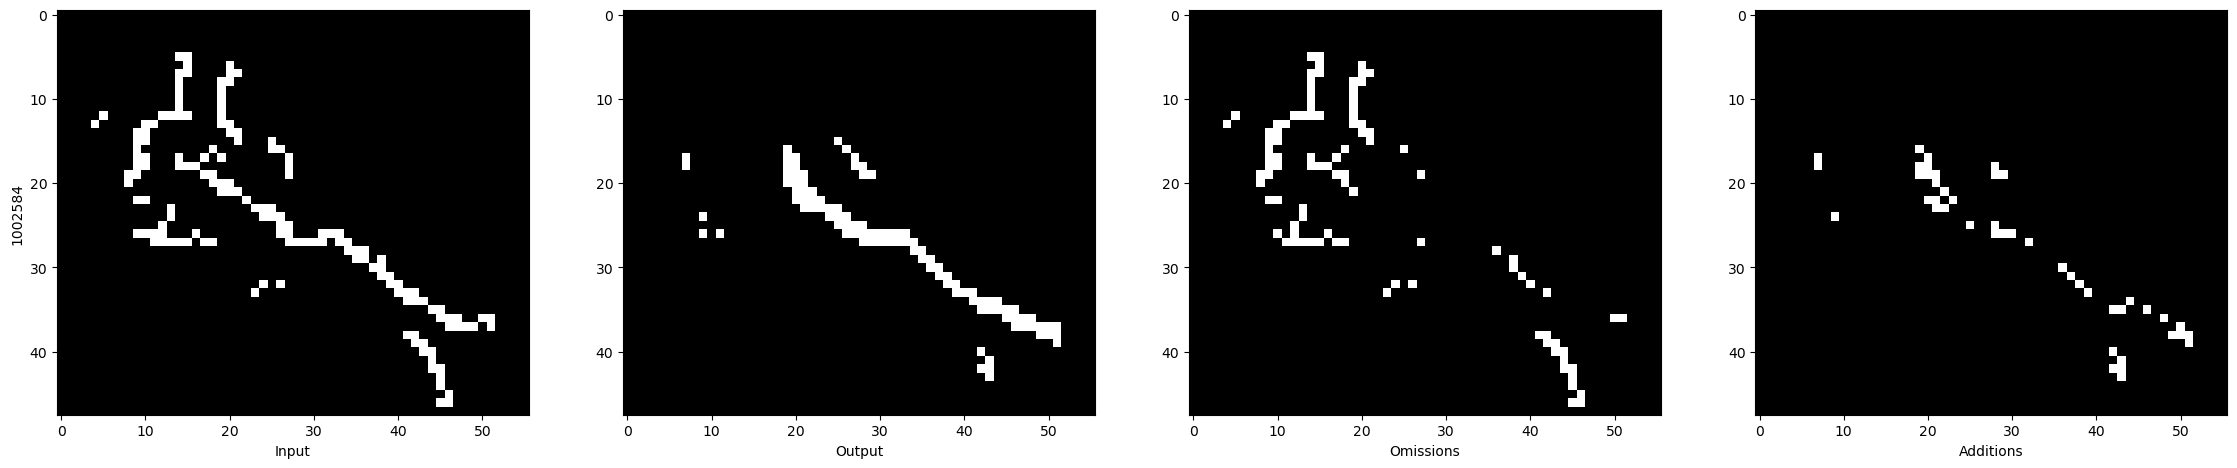

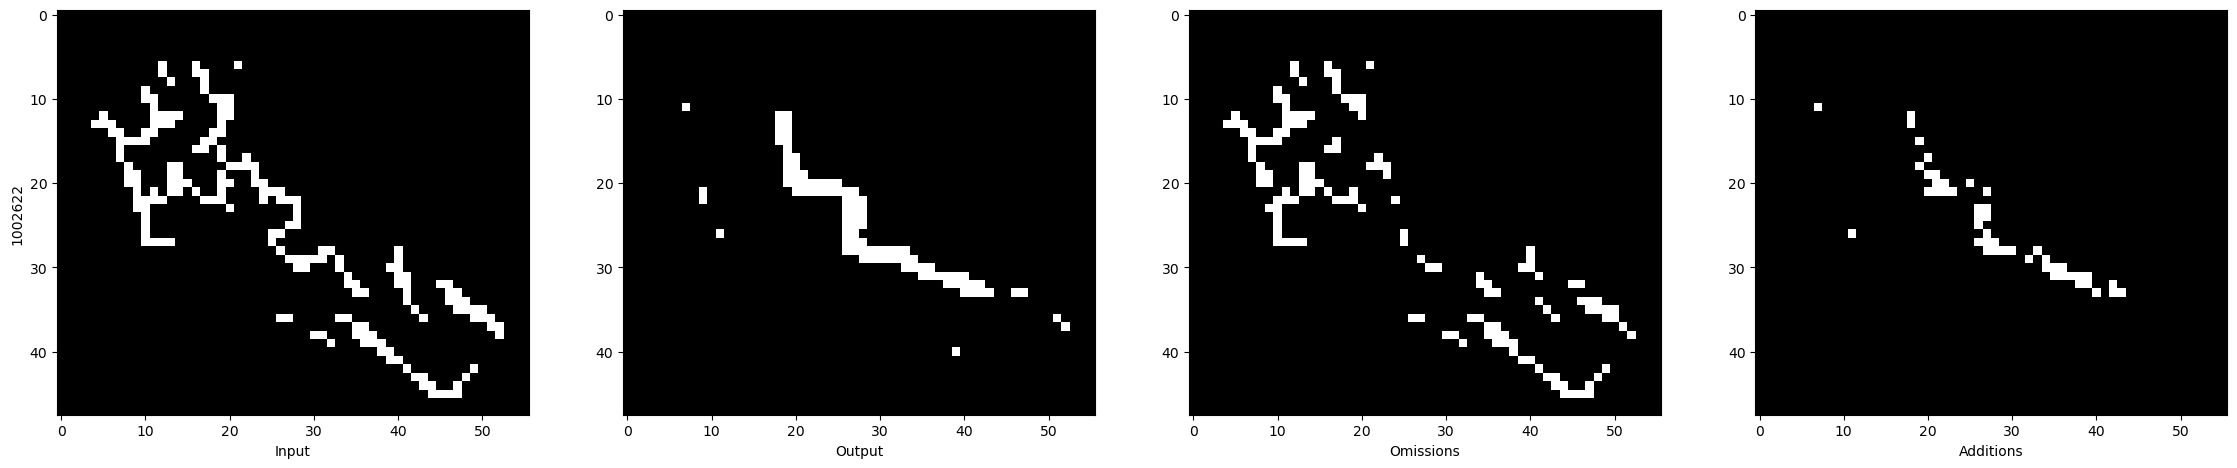

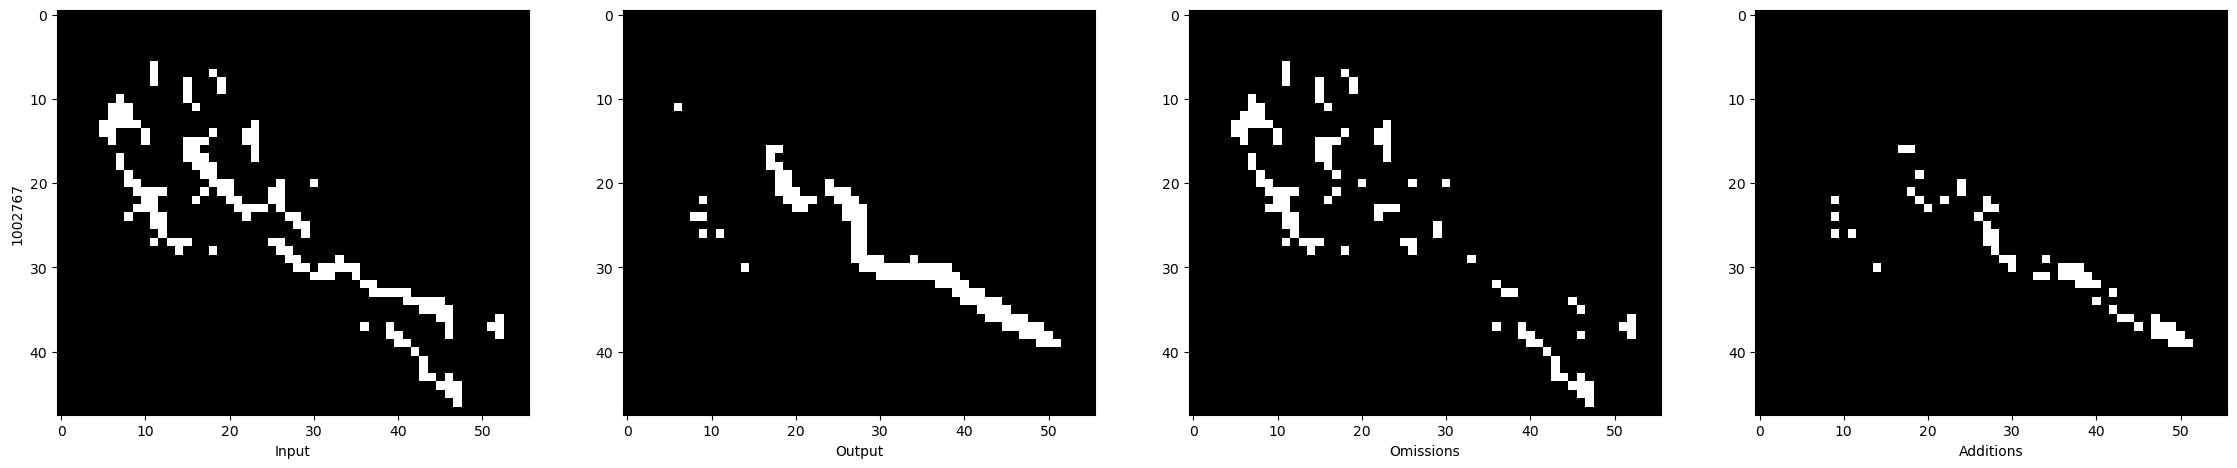

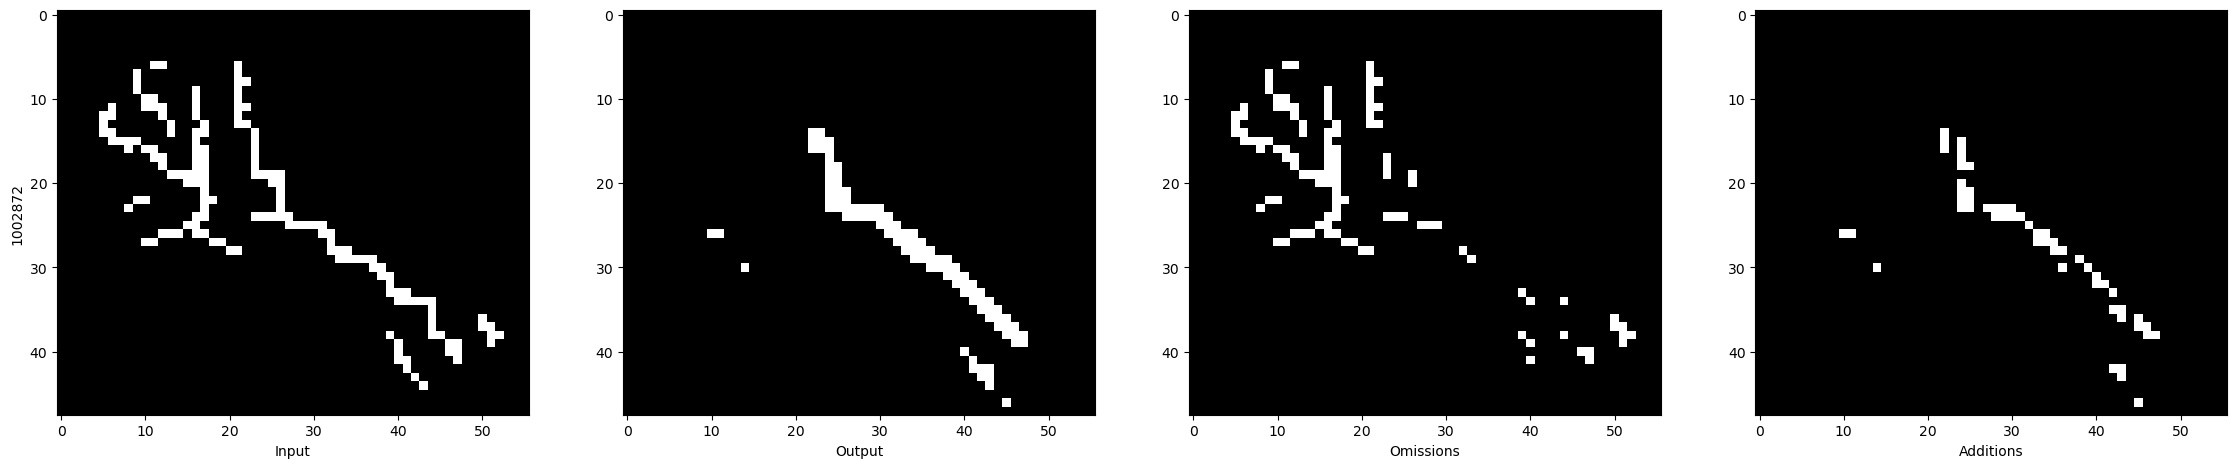

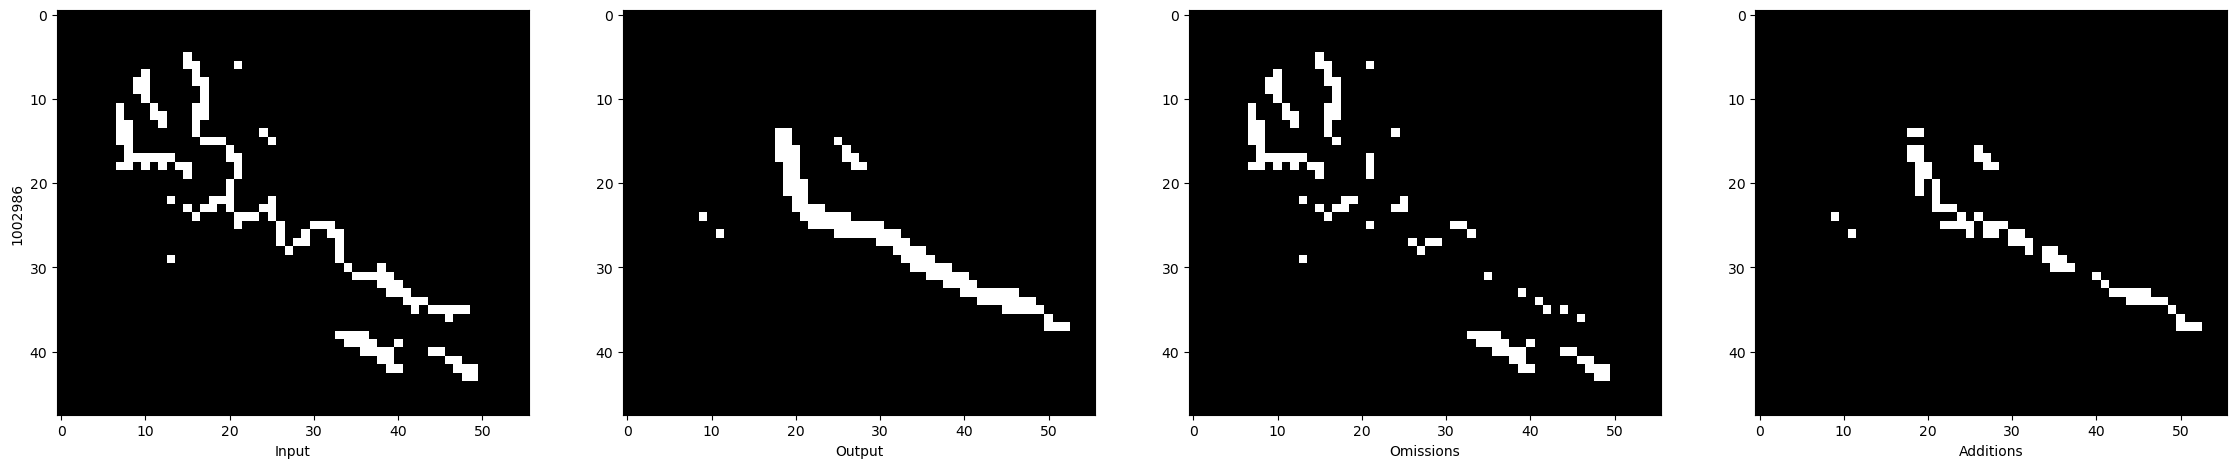

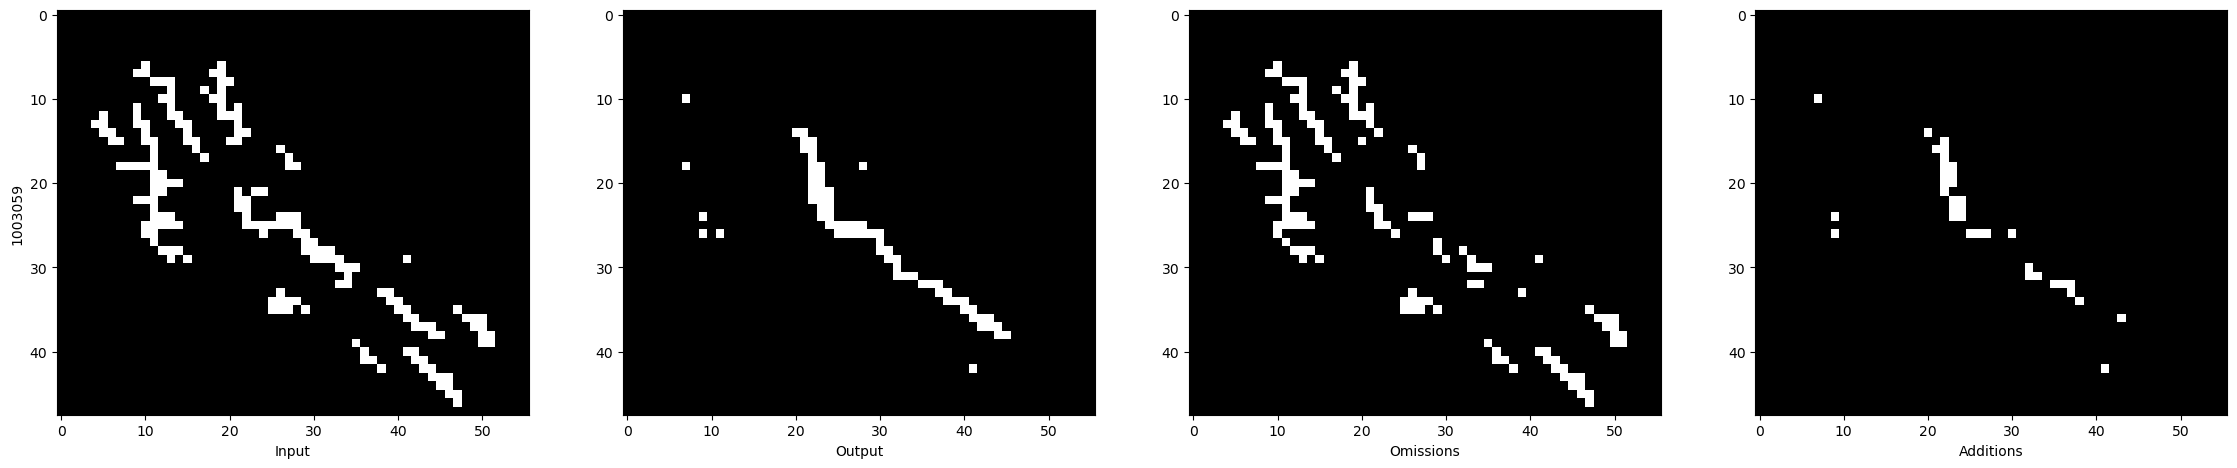

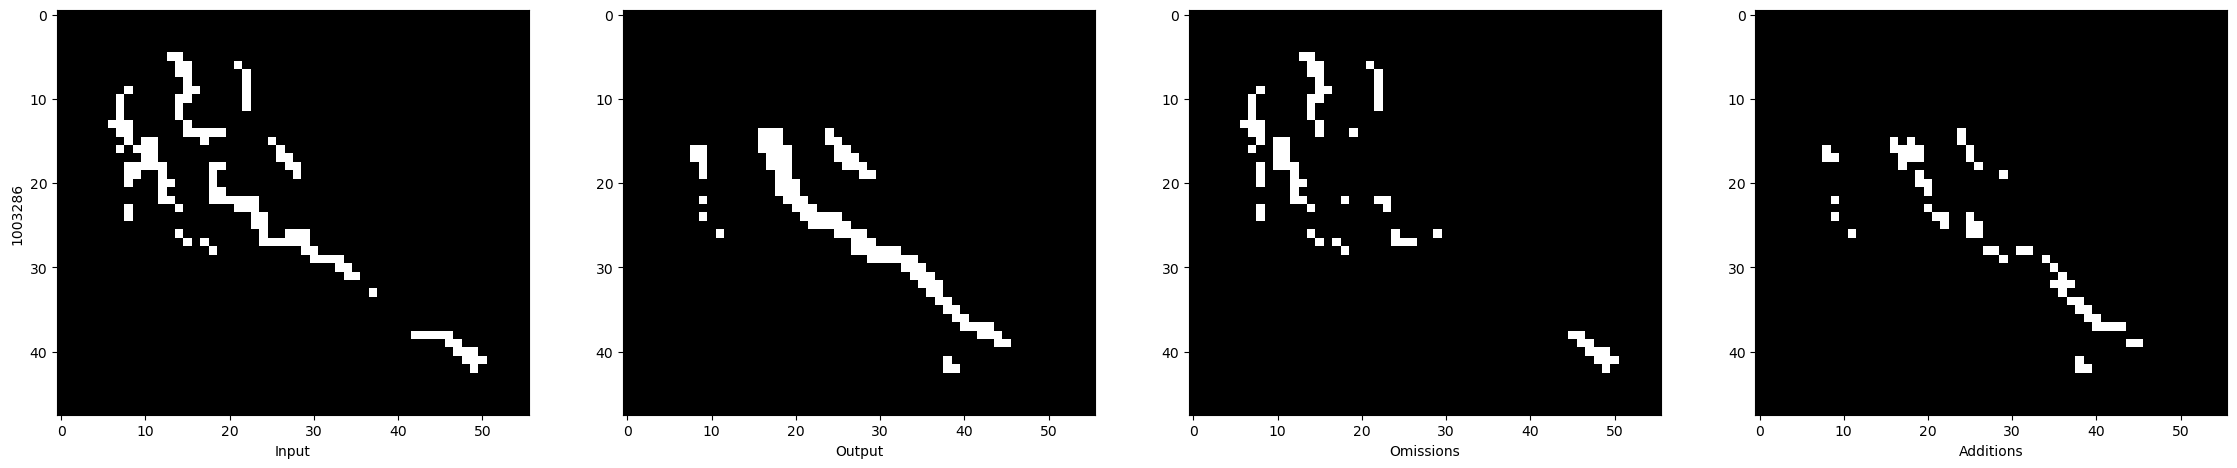

In [572]:
#dHCP preterms reconstructions

depth=16
number=15

for idx, subject in enumerate(ordered_subjects_ukb[0].tolist()[:number]):
    fig, axs = plt.subplots(ncols=4, figsize=(28,7))
    input = np.rot90(ukb_skels[idx][depth,:,:], axes=(1, 0))
    output = np.rot90(ukb_reconstructions[idx][depth,:,:], axes=(1,0))
    axs[0].imshow(input, cmap='gray')
    axs[0].set_xlabel('Input')
    axs[1].imshow(output, cmap='gray')
    axs[1].set_xlabel('Output')
    axs[2].imshow((input.astype(int)-output.astype(int)) == 1, cmap='gray')
    axs[2].set_xlabel('Omissions')
    axs[3].imshow((output.astype(int)-input.astype(int)) == 1, cmap='gray')
    axs[3].set_xlabel('Additions')
    axs[0].set_ylabel(subject)
    plt.savefig(save_dir+'Reconstructions'+'/UKB/'+f'/Reconstruction_{subject}', facecolor='white')
plt.show()